In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras import layers, preprocessing
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf
from tensorflow import keras


# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm



In [17]:
import os

In [18]:
#Cargo el modelo

# Specify the path to your saved model file (.h5 or .hdf5 format)
model_path = 'modelos/jorgenet_combined.h5'

# Load the model*
model = tf.keras.models.load_model(model_path)



In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 255, 255, 3)       0

In [19]:
# Set the random seed for TensorFlow operations
tf.random.set_seed(123)

# Set the random seed for NumPy operations (if used in your code)
np.random.seed(123)

In [20]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(img)    
    x = np.expand_dims(x, axis=0)
    return x

In [21]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=1):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


In [23]:
# Remove last layer's softmax
model.layers[-1].activation = None
img_size = (225, 225)

In [37]:

# Load and preprocess the image
image_path = 'test_set_private/scc_10_40X.jpg'
# Prepare image
img_array = get_img_array(image_path, size=img_size)


FileNotFoundError: [Errno 2] No such file or directory: 'test_set_private/scc_10_40X.jpg'

In [34]:

# Print what the top predicted class is
preds = model.predict(img_array)


print(np.argmax(preds))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_4')

1


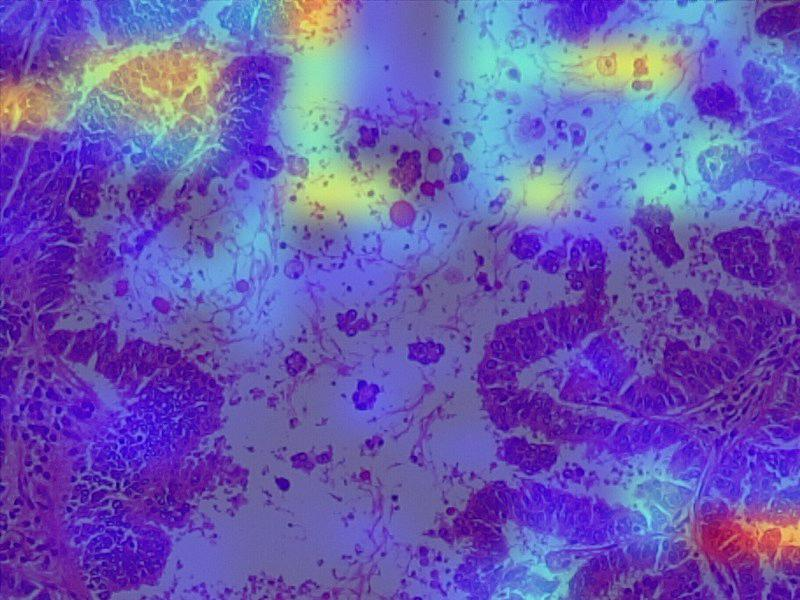

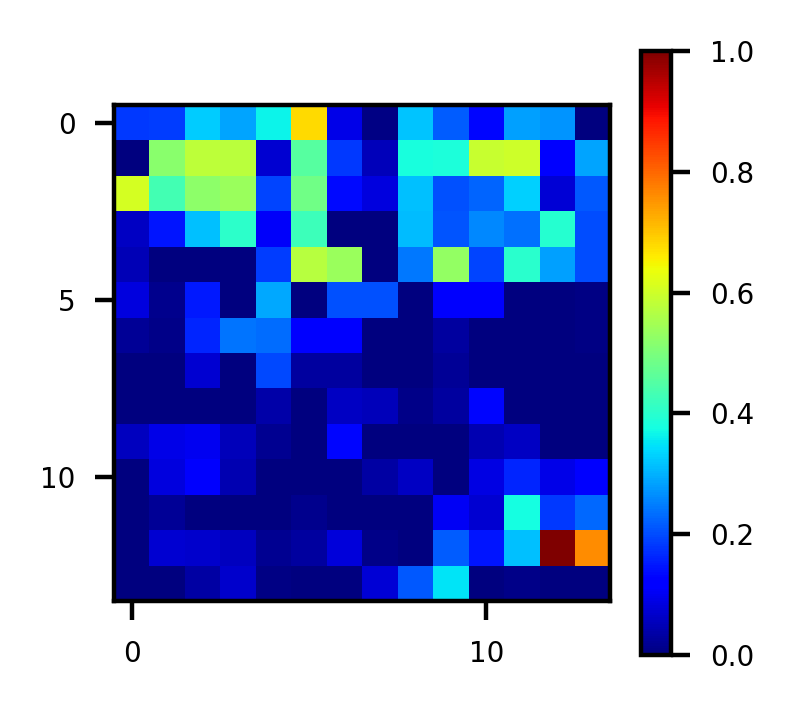

In [35]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_4')
# Display heatmap

# Create a larger figure and set the resolution
plt.figure(figsize=(2, 2), dpi=400)

# Display the heatmap with more details
plt.imshow(heatmap, cmap='jet',  interpolation='nearest')

# Add a colorbar for reference
plt.colorbar().ax.tick_params(labelsize=5)
# Set the font size of the tick labels
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)


save_and_display_gradcam(image_path, heatmap)


In [30]:
folder_path = 'to_explain_images'
output_folder = 'GRADCAM_explained_images'

Image: aca_bd_20x_6_0_0.jpg, Predicted Class: 1


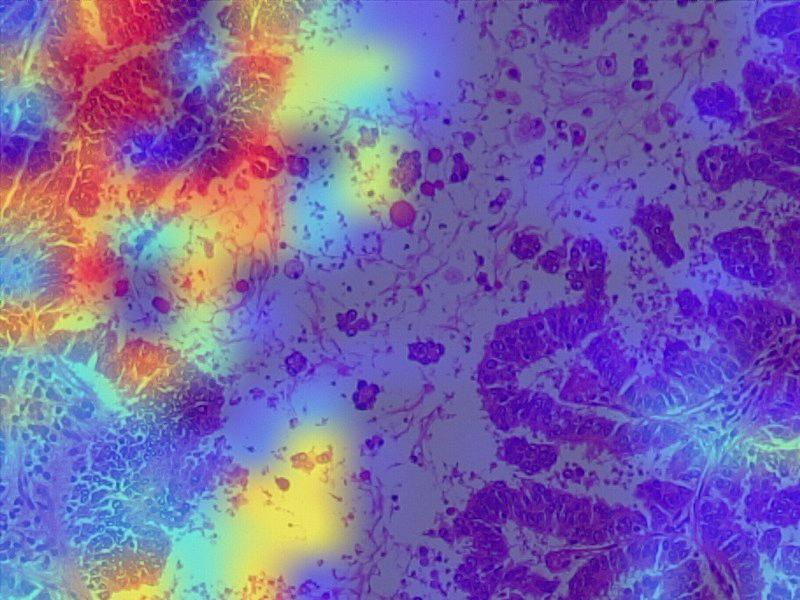

Image: aca_bd_20x_7_1_1.jpg, Predicted Class: 2


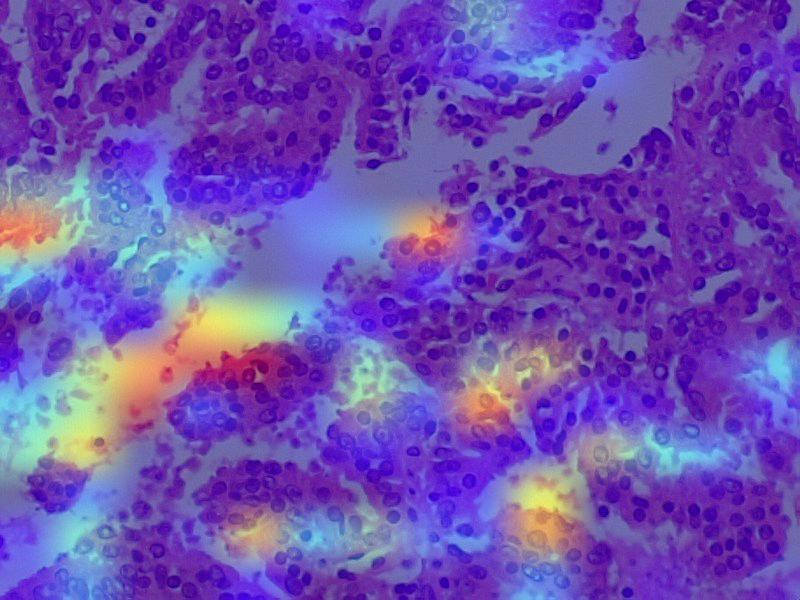

Image: aca_bd_40x_19x_1_1.jpg, Predicted Class: 0


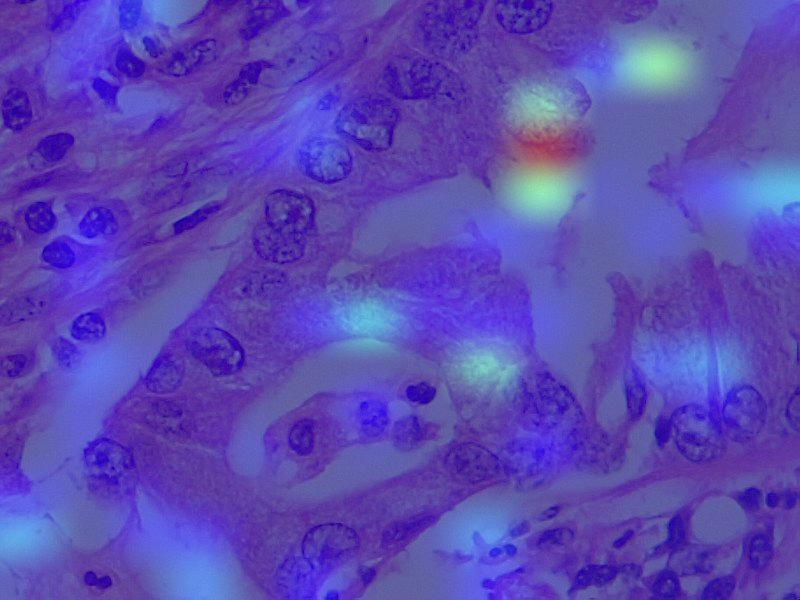

Image: aca_bd_40x_20_1_1.jpg, Predicted Class: 0


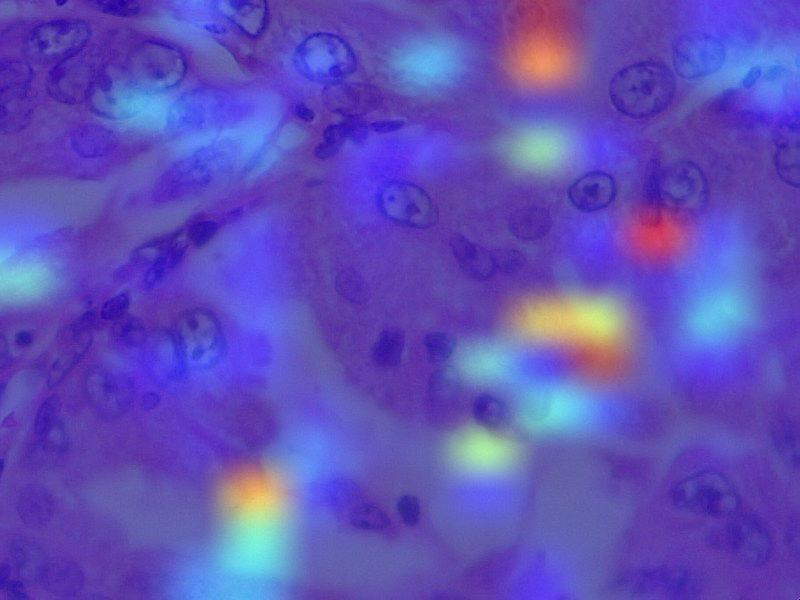

Image: aca_h_20x_550.jpg, Predicted Class: 0


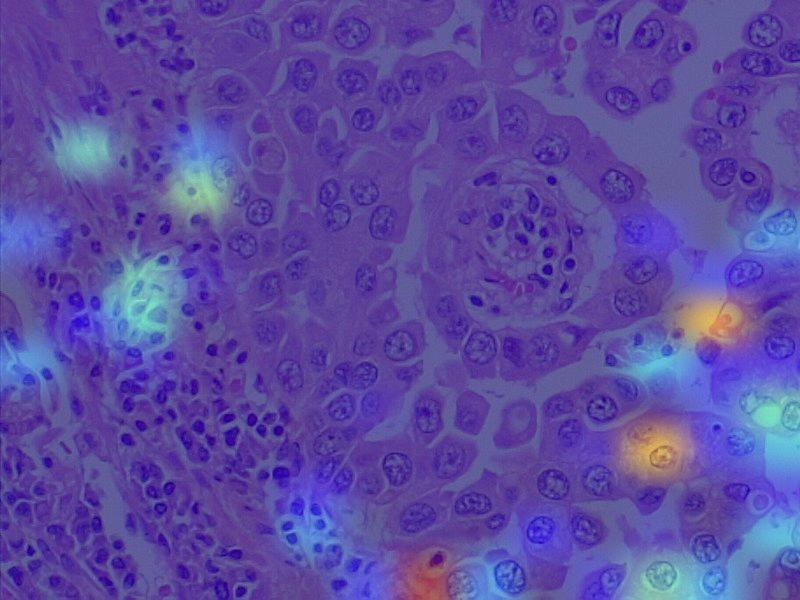

Image: aca_h_20x_608.jpg, Predicted Class: 0


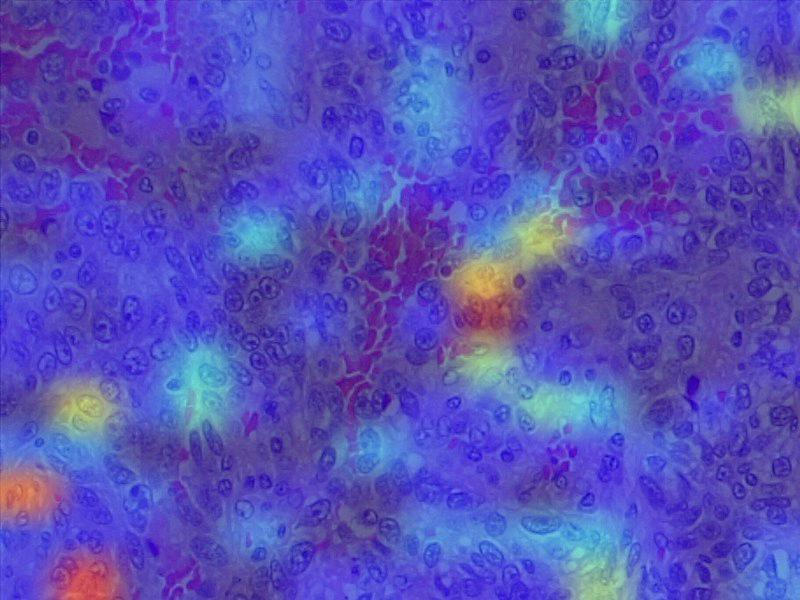

Image: aca_h_40x_113.jpg, Predicted Class: 0


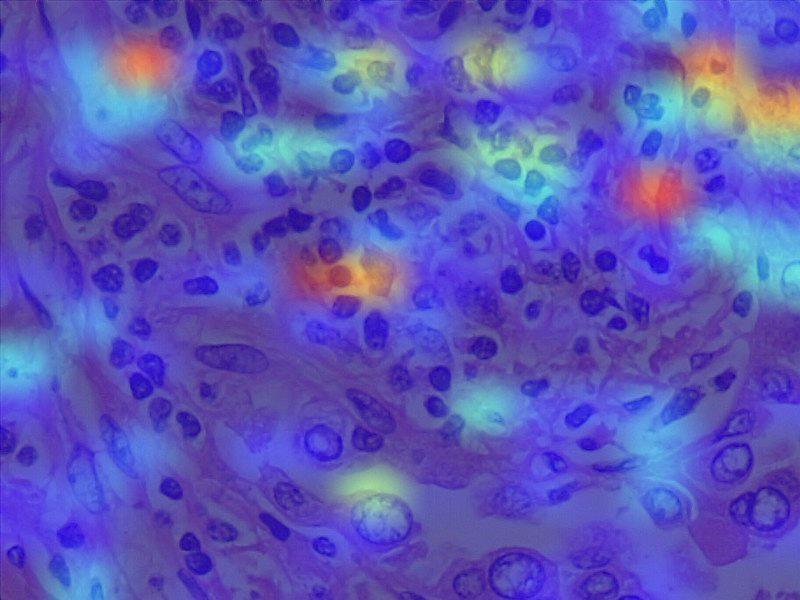

Image: aca_h_40x_144.jpg, Predicted Class: 0


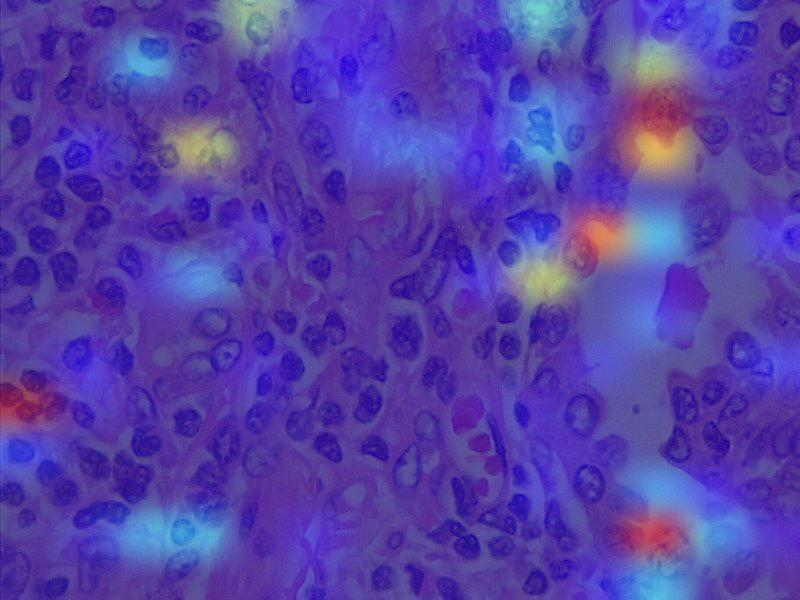

Image: lungaca1.jpeg, Predicted Class: 0


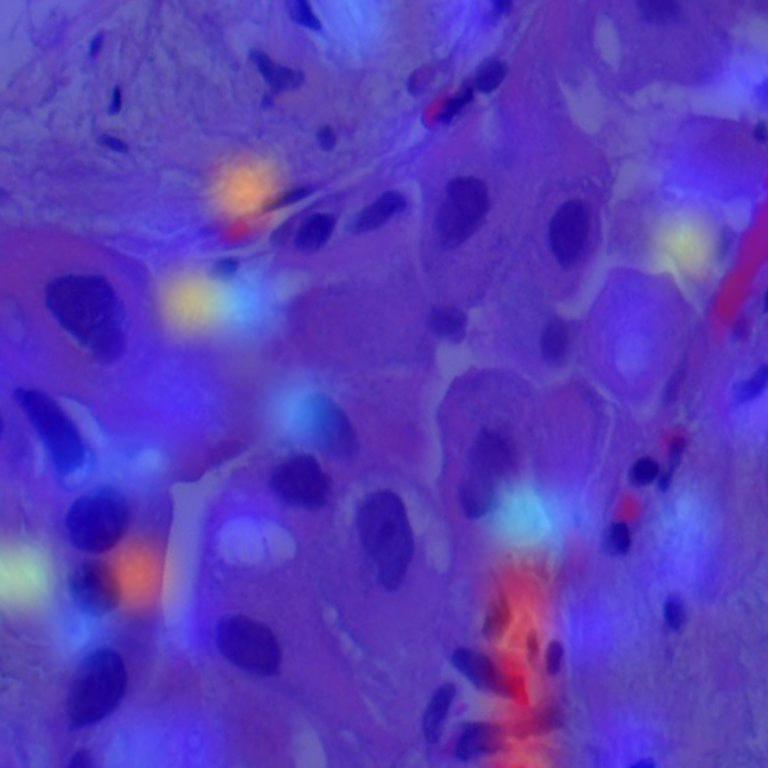

Image: lungaca2.jpeg, Predicted Class: 0


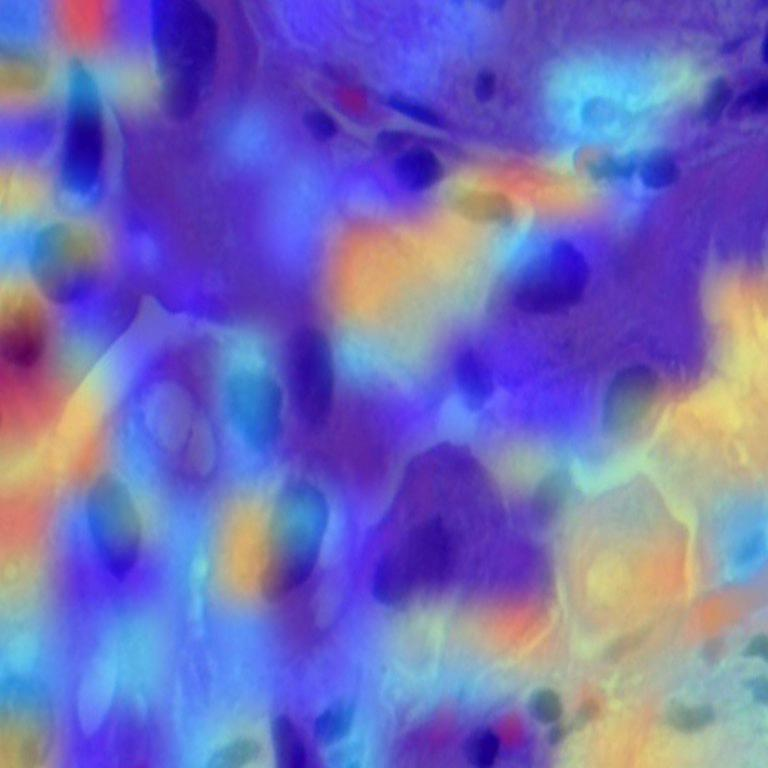

Image: lungaca3.jpeg, Predicted Class: 0


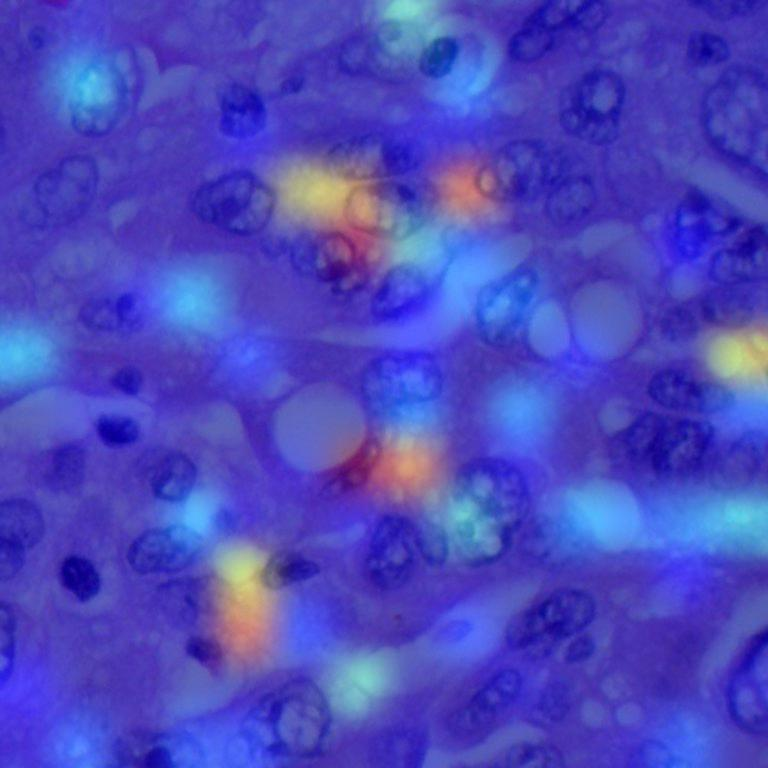

Image: lungn1.jpeg, Predicted Class: 1


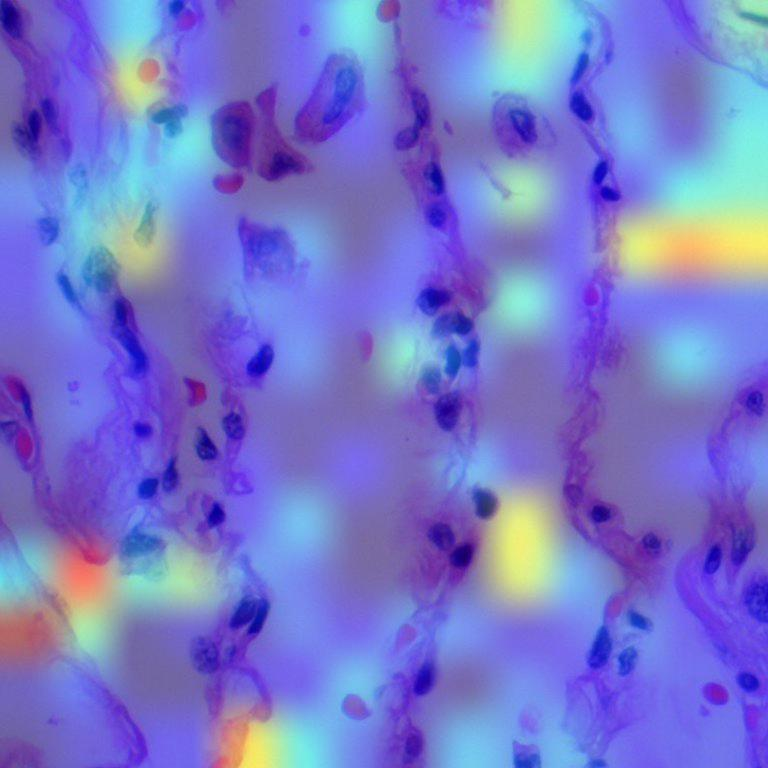

Image: lungn2.jpeg, Predicted Class: 1


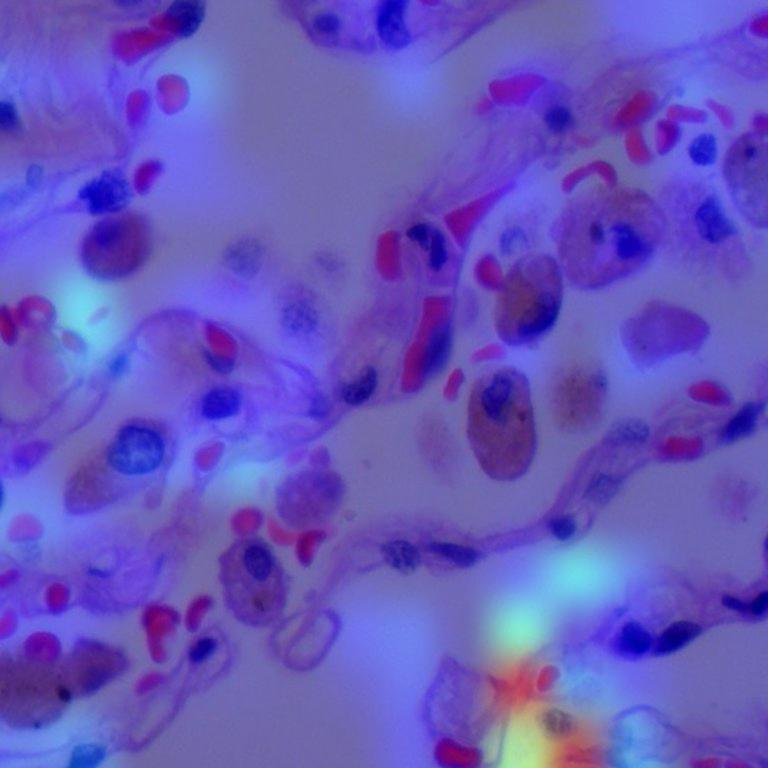

Image: lungn3.jpeg, Predicted Class: 1


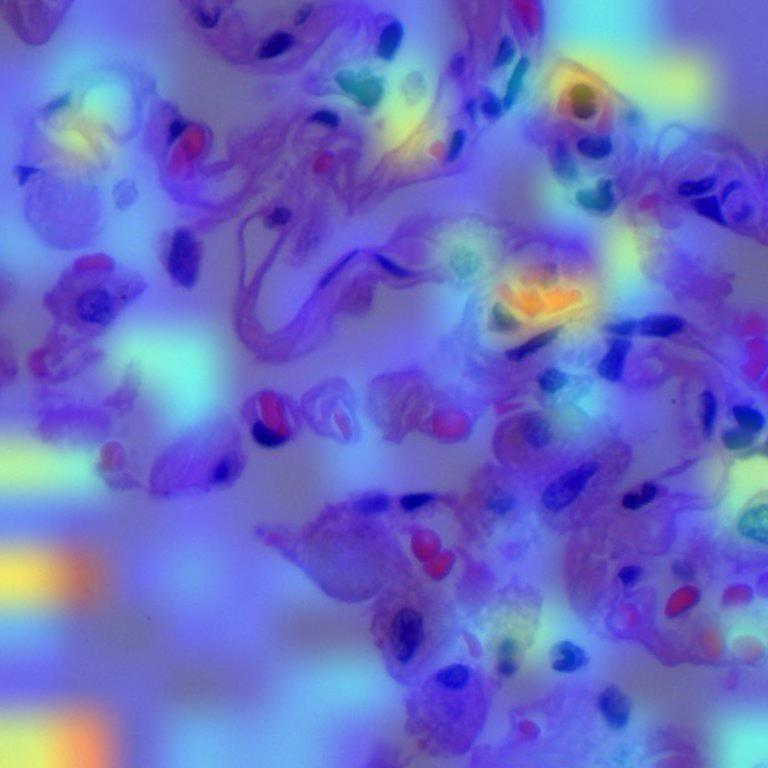

Image: lungscc27.jpeg, Predicted Class: 2


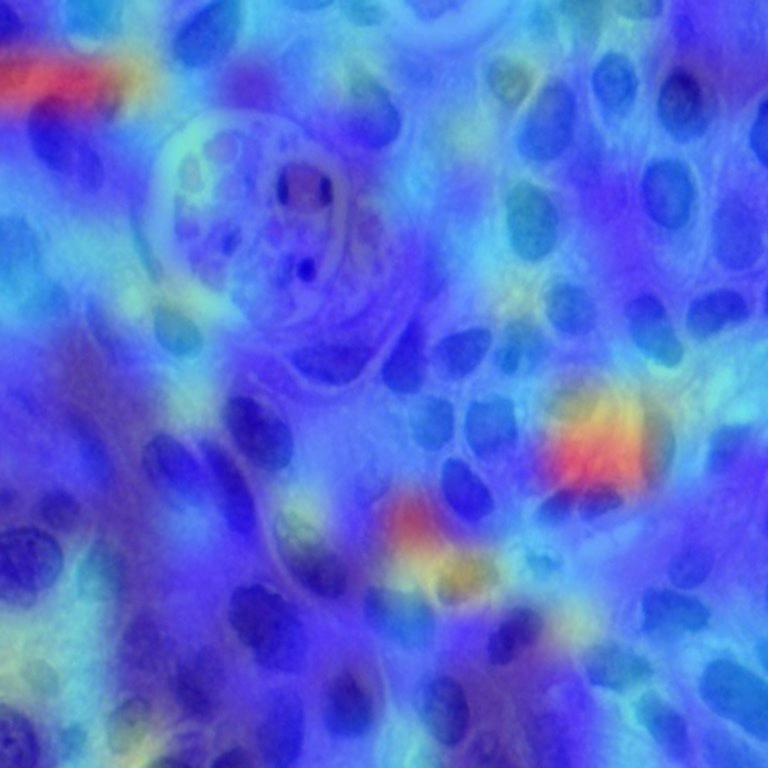

Image: lungscc28.jpeg, Predicted Class: 2


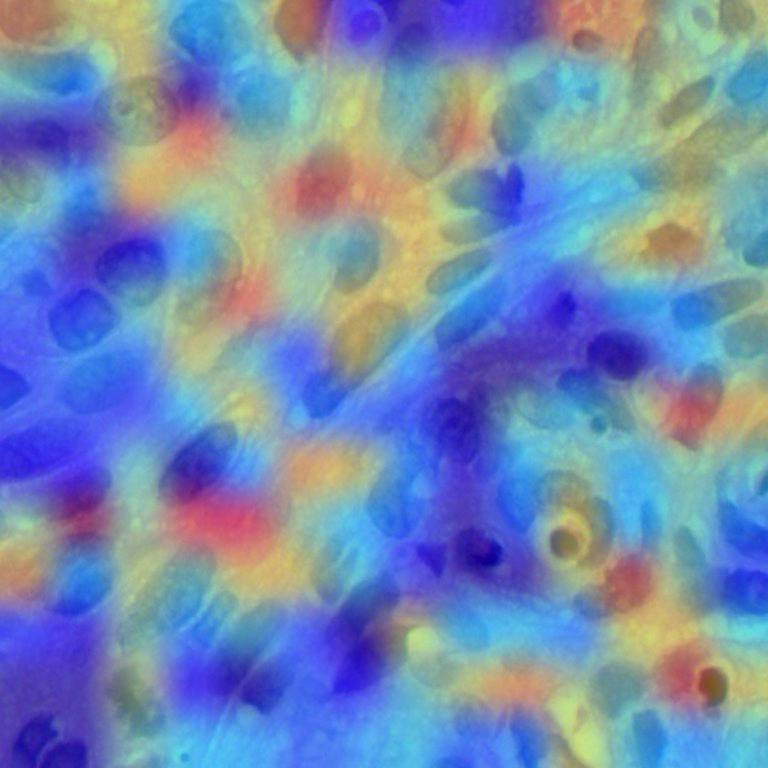

Image: lungscc29.jpeg, Predicted Class: 2


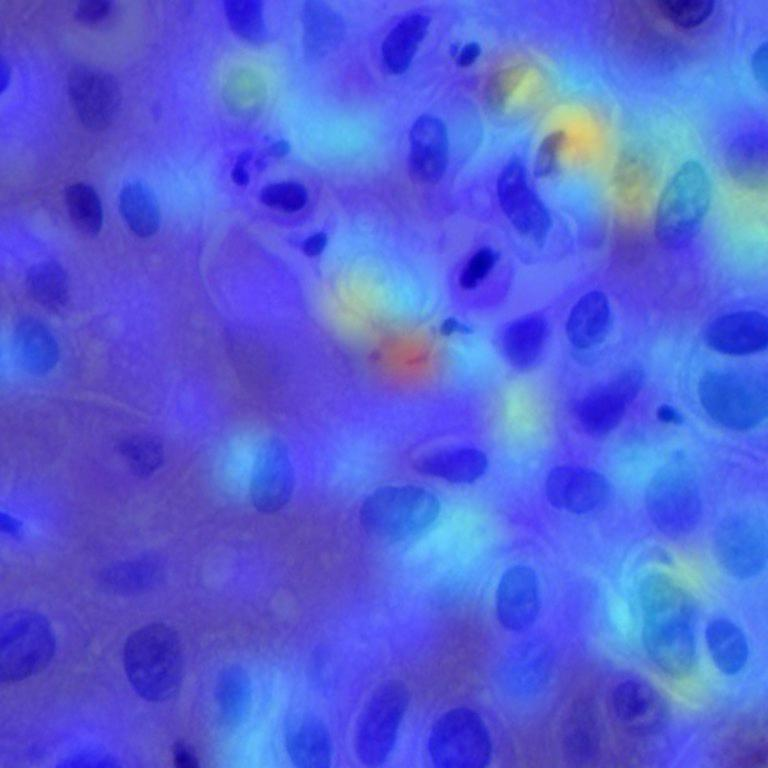

Image: nor_20x_16_0_0.jpg, Predicted Class: 1


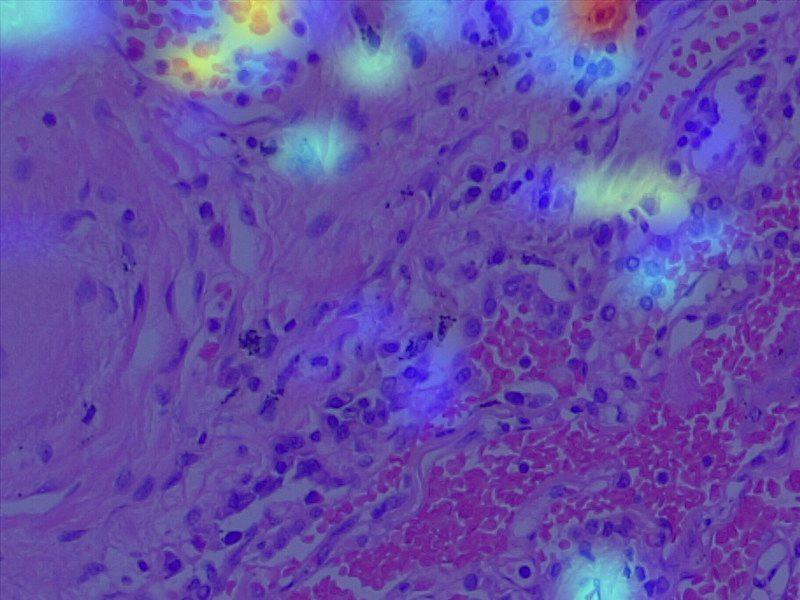

Image: nor_20x_23_1_0.jpg, Predicted Class: 1


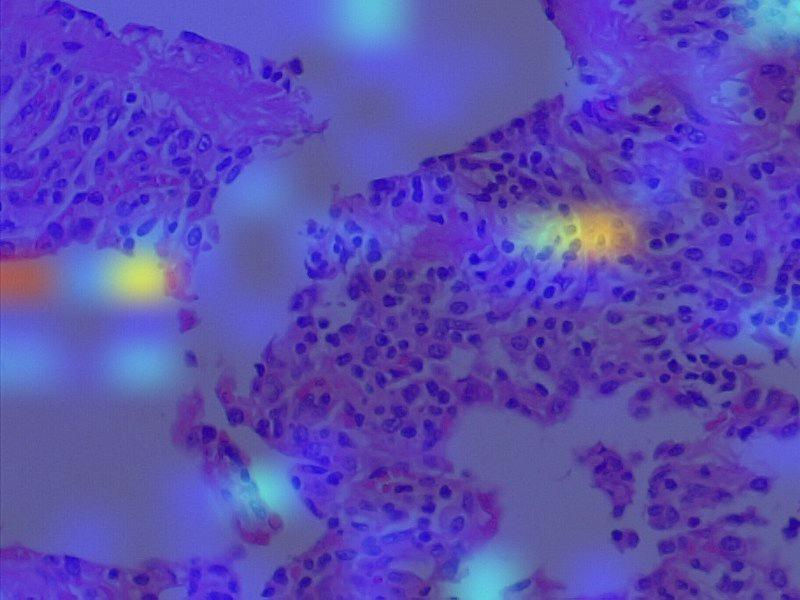

Image: nor_40x_112_1_1_.jpg, Predicted Class: 1


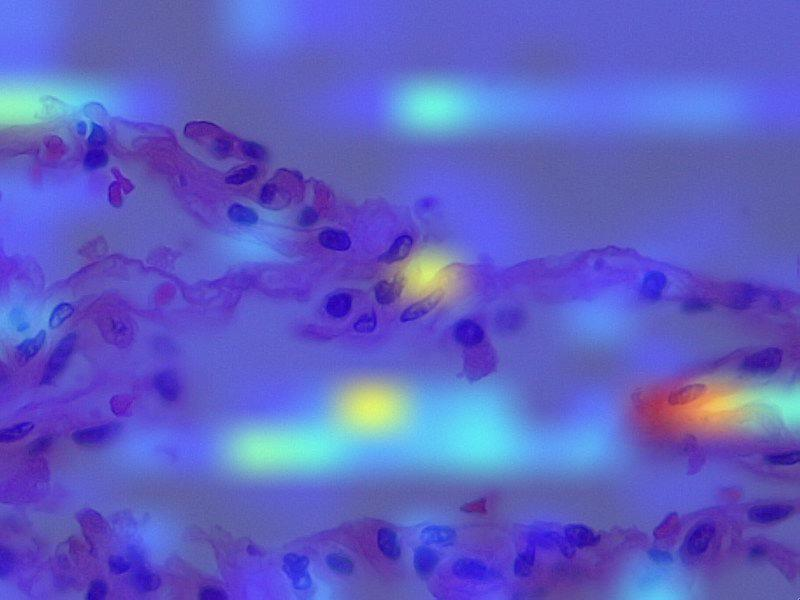

Image: nor_40x_116_1_1_.jpg, Predicted Class: 1


C:\Users\diosdadj\AppData\Local\Temp\ipykernel_37956\207548562.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2, 2), dpi=400)


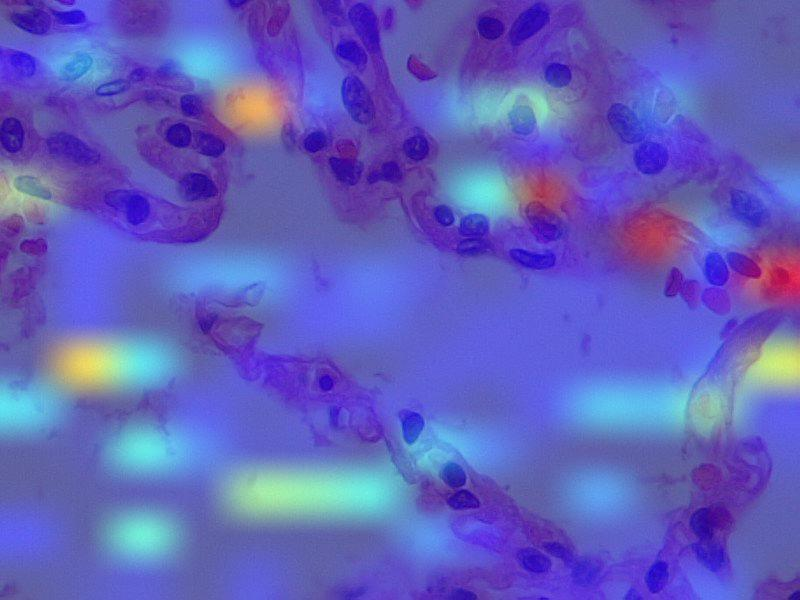

Image: nor_40x_14_1_0.jpg, Predicted Class: 1


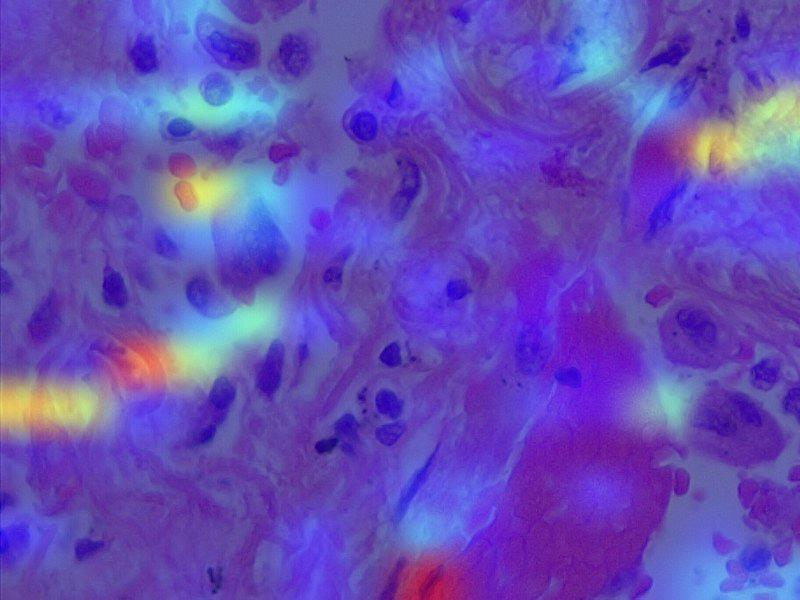

Image: nor_40x_15_1_1.jpg, Predicted Class: 0


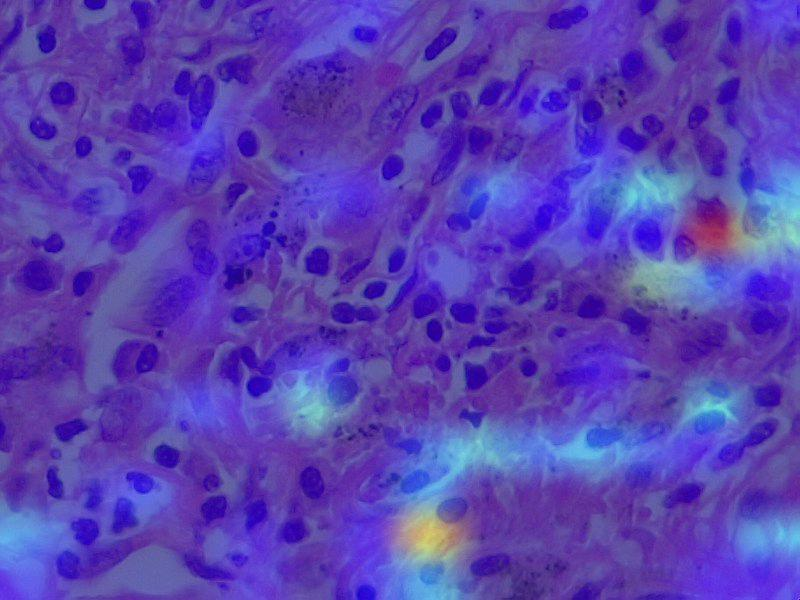

Image: scc_bd_20x_34_0_0.jpg, Predicted Class: 2


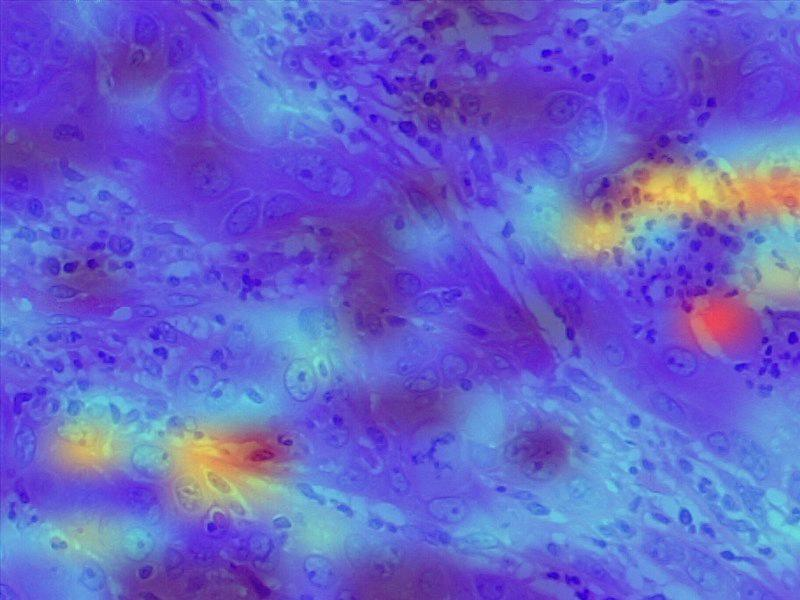

Image: scc_bd_20x_40_0_1.jpg, Predicted Class: 2


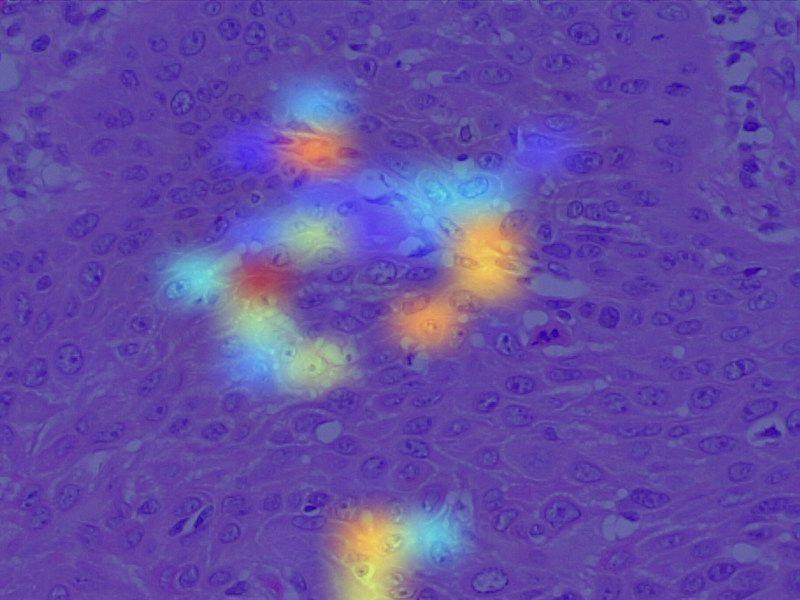

Image: scc_bd_40x_27_1_1.jpg, Predicted Class: 2


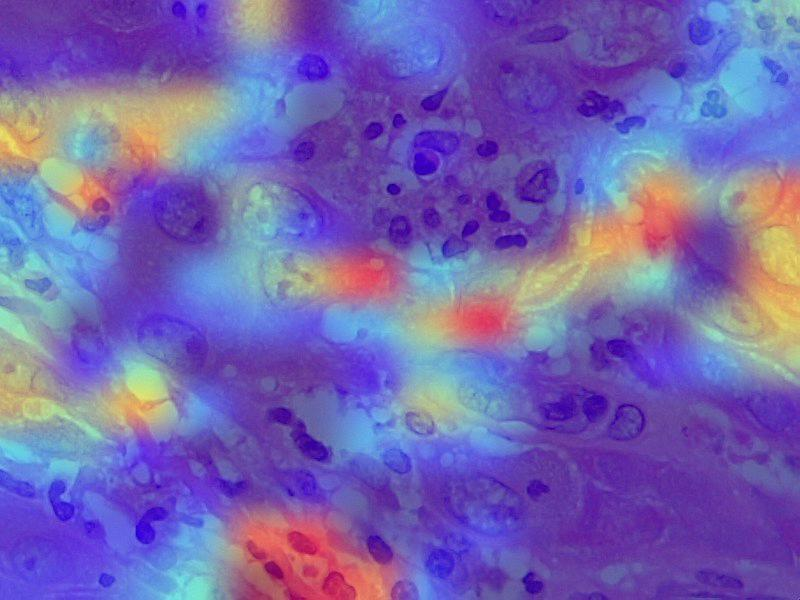

Image: scc_bd_40x_35_1_0.jpg, Predicted Class: 0


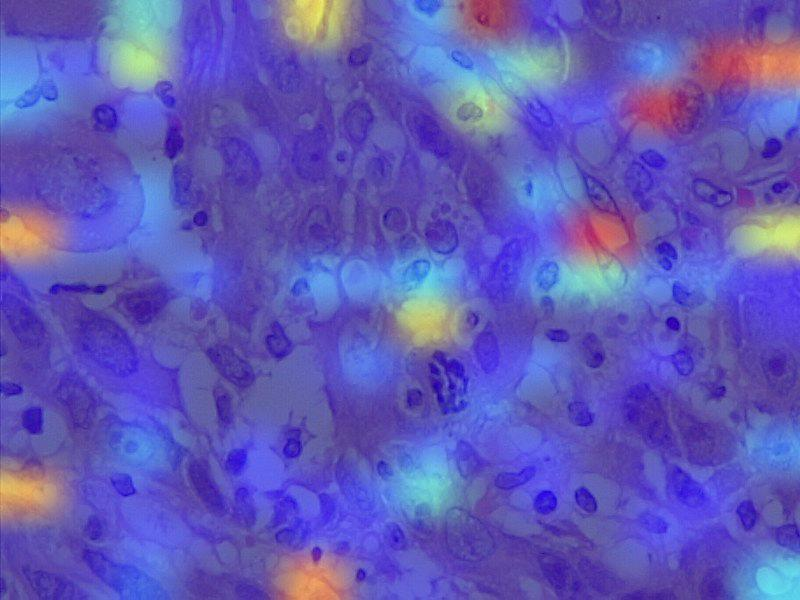

Image: scc_h_20x_496.jpg, Predicted Class: 2


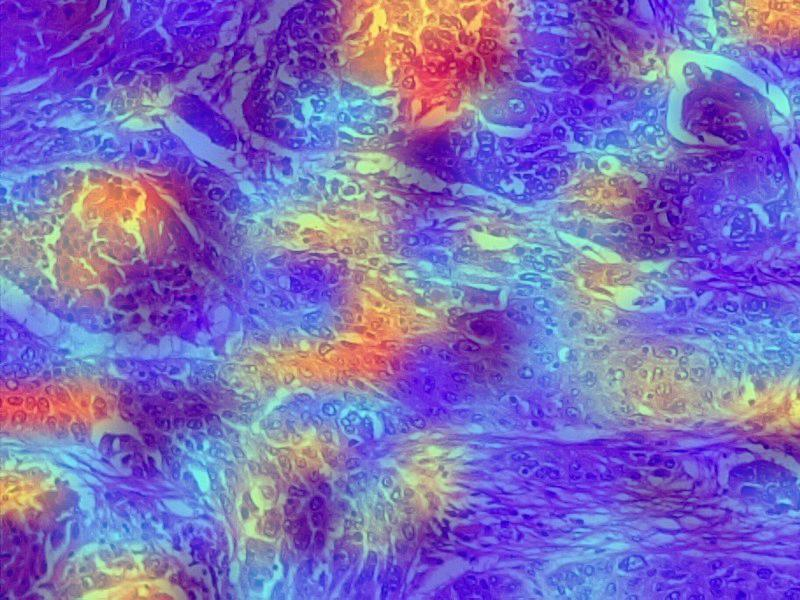

Image: scc_h_20x_527.jpg, Predicted Class: 2


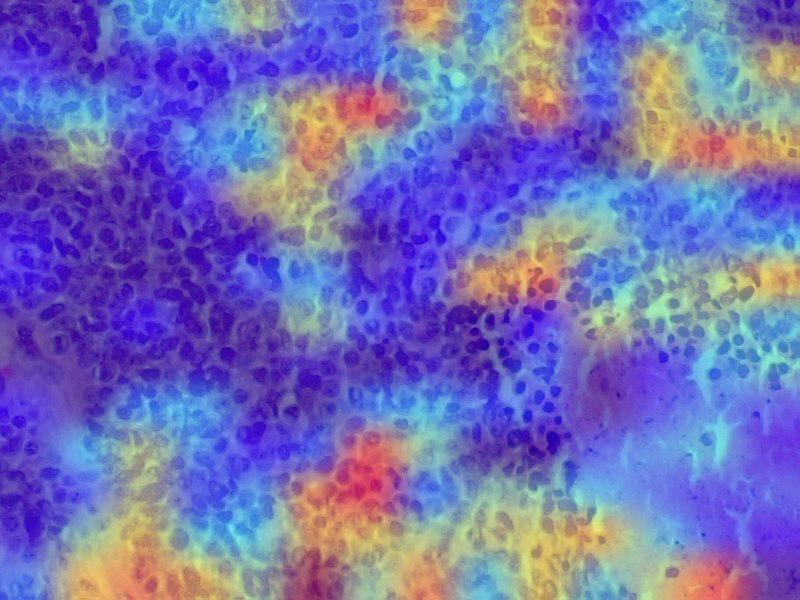

Image: scc_h_40x_211.jpg, Predicted Class: 2


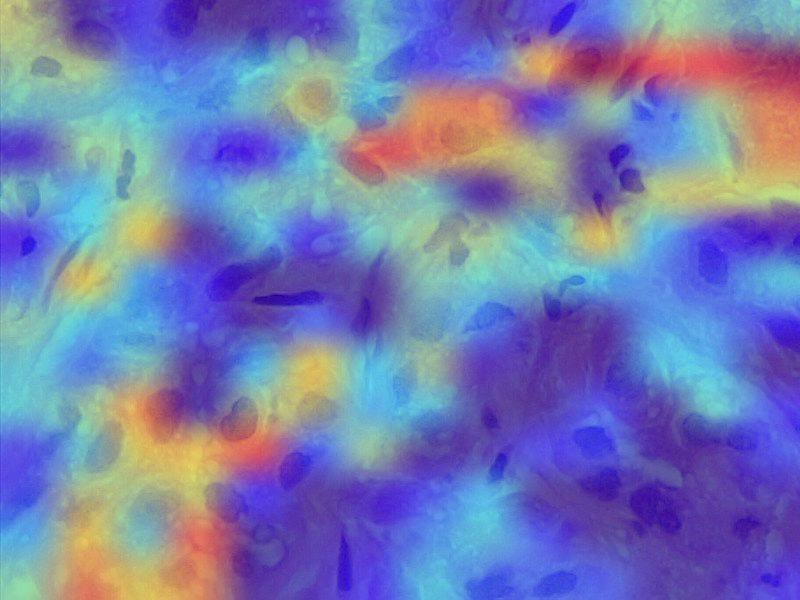

Image: scc_h_40x_40.jpg, Predicted Class: 2


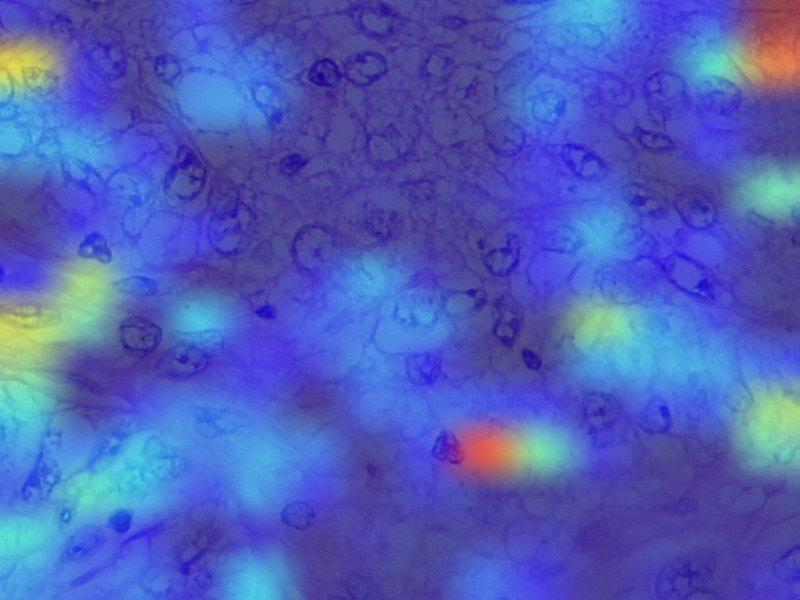

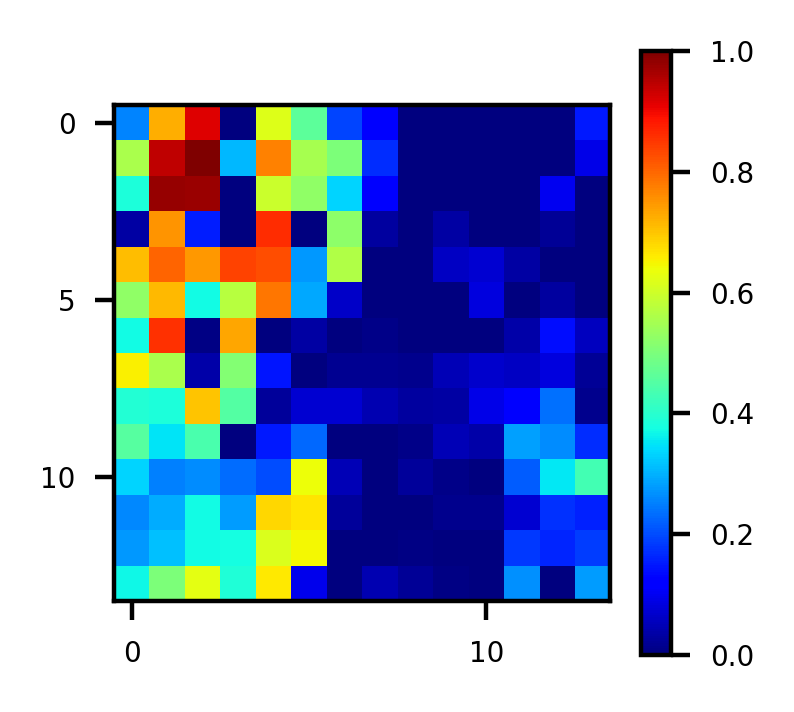

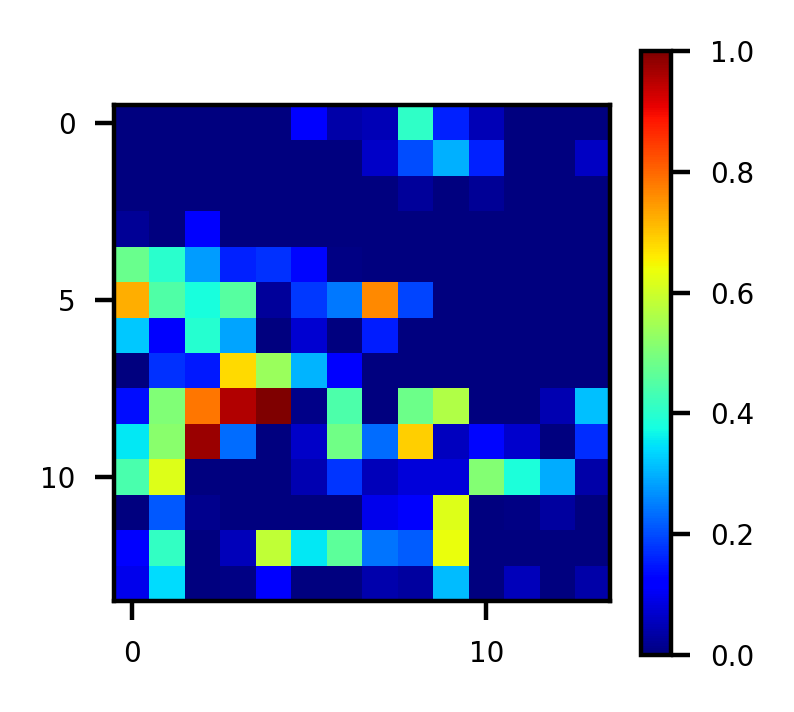

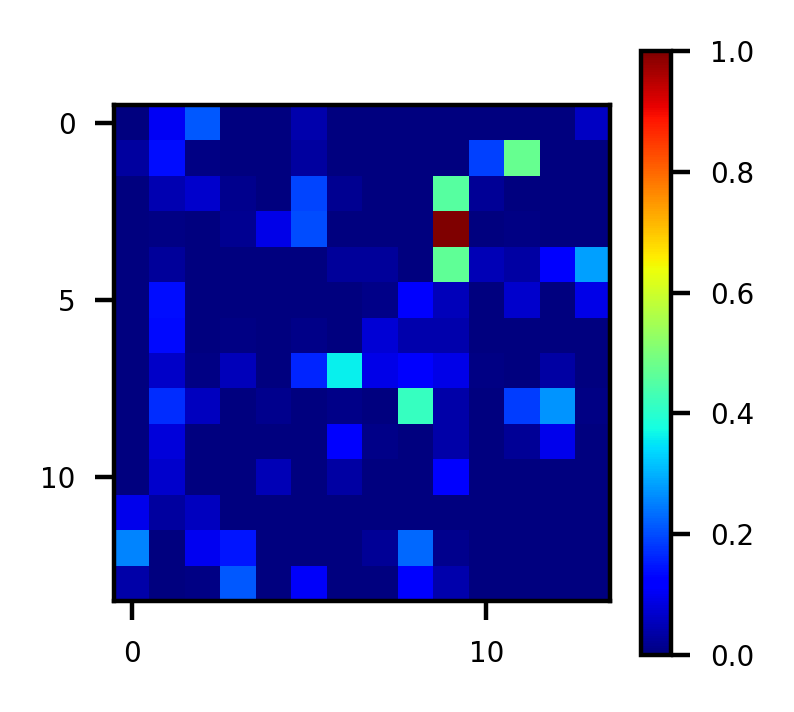

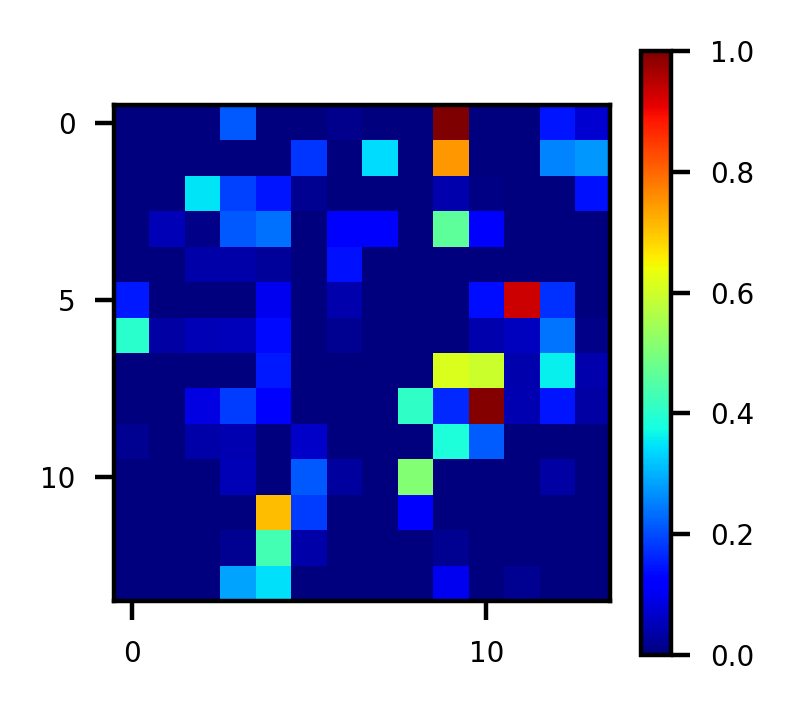

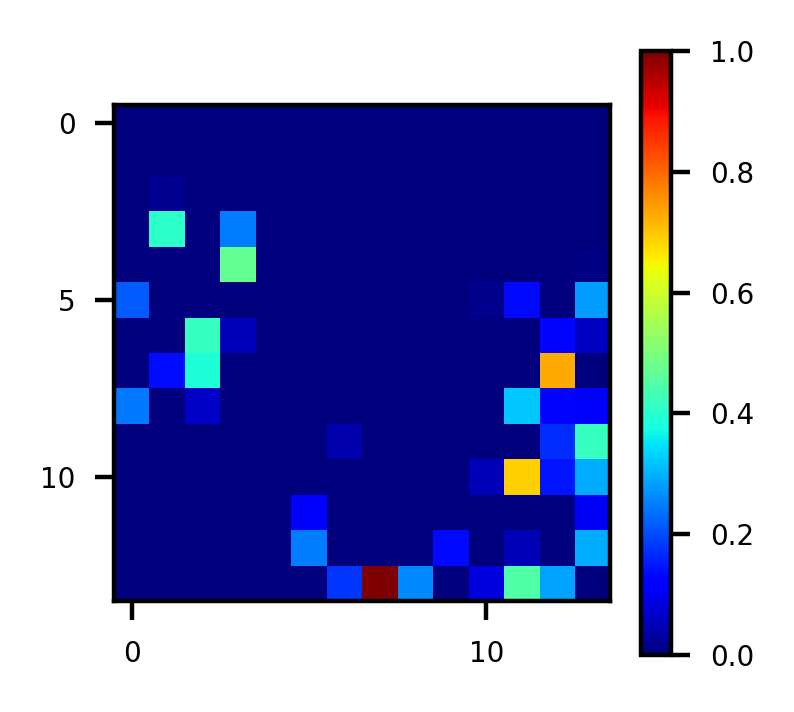

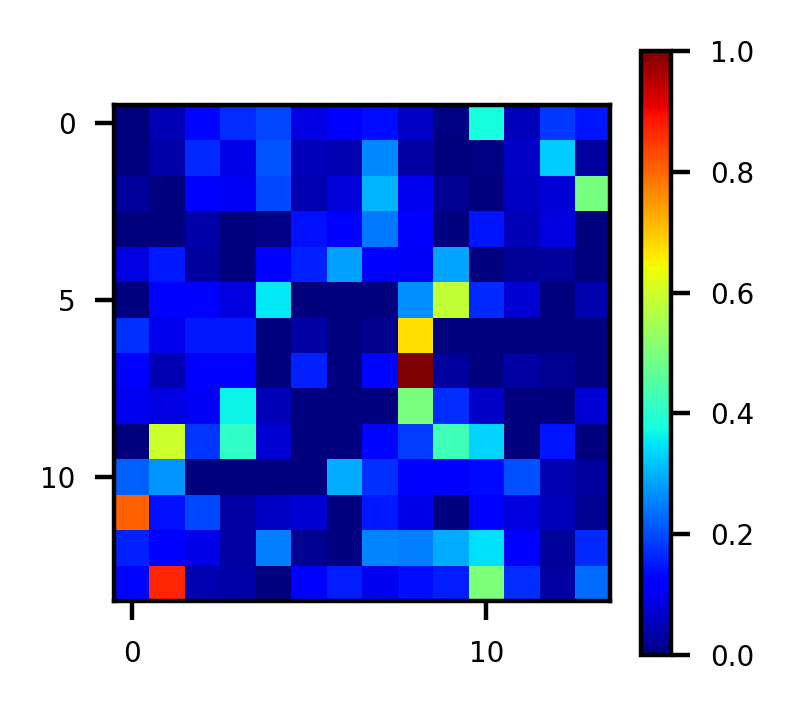

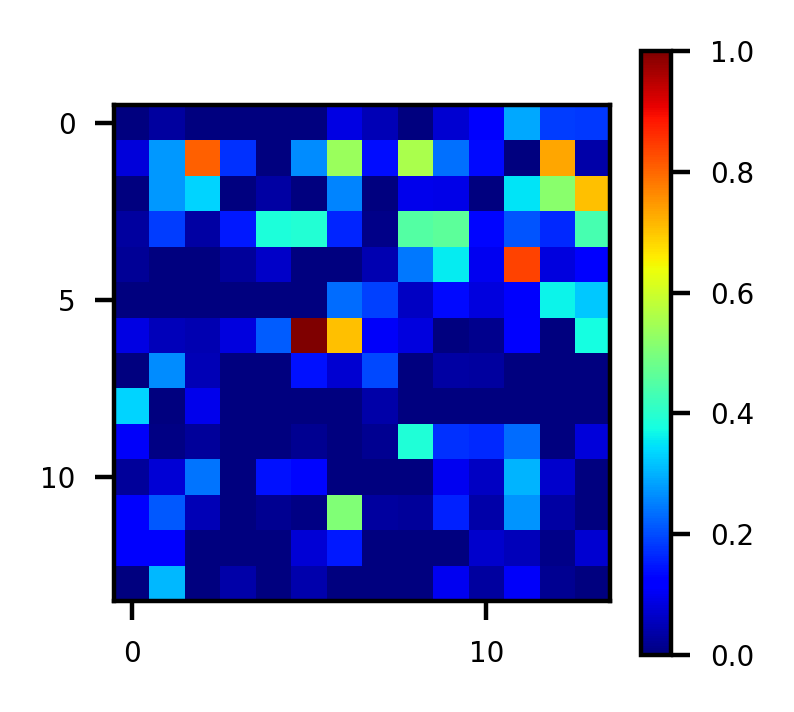

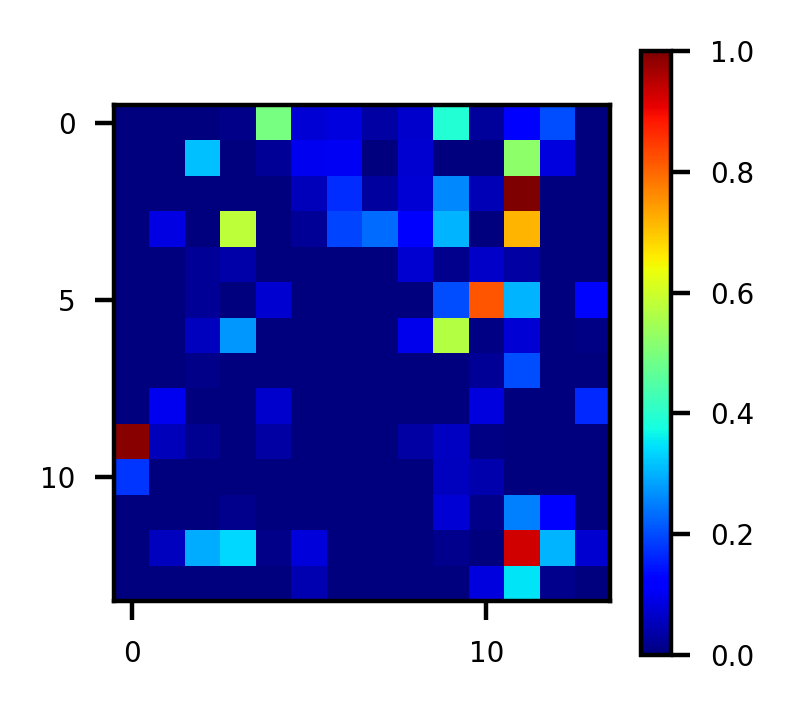

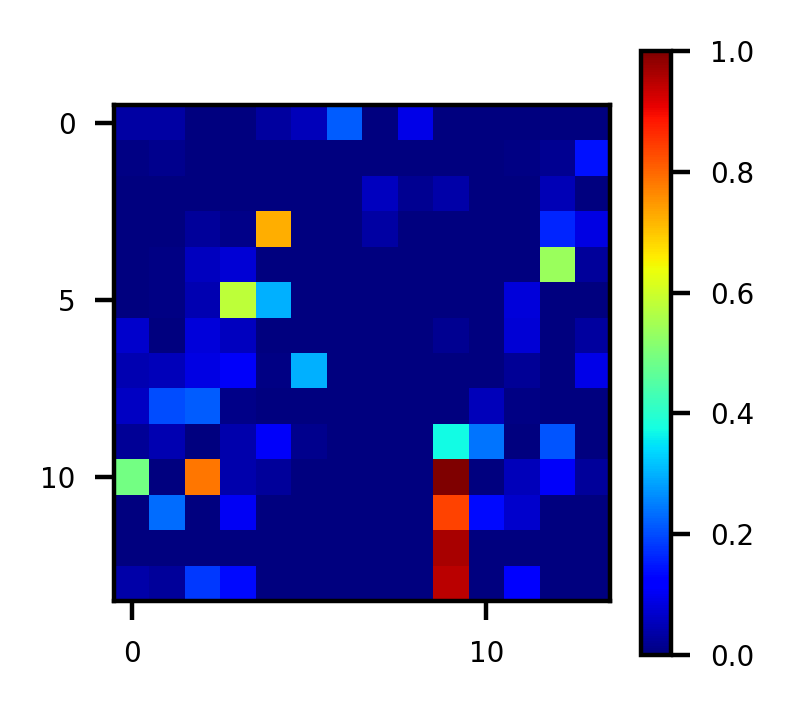

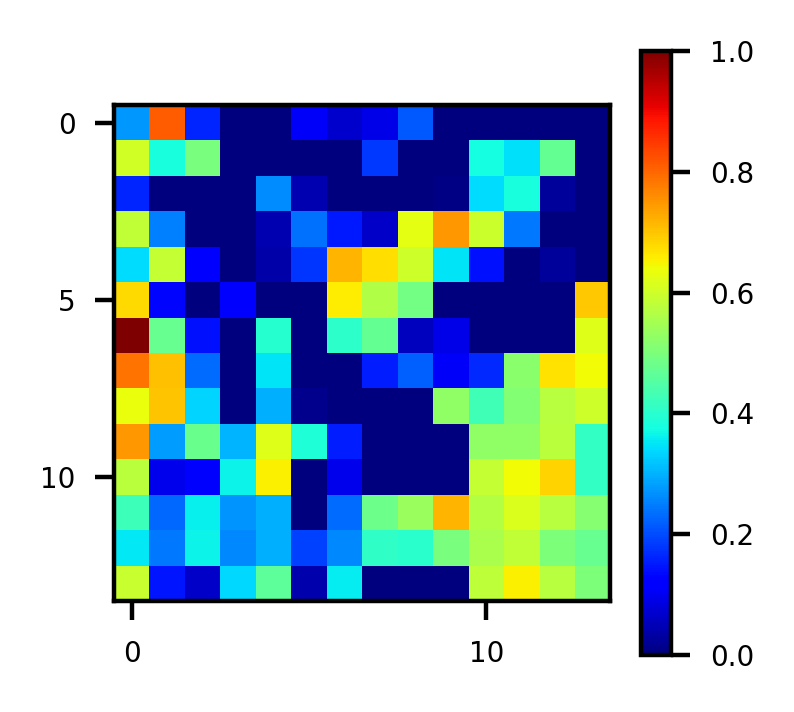

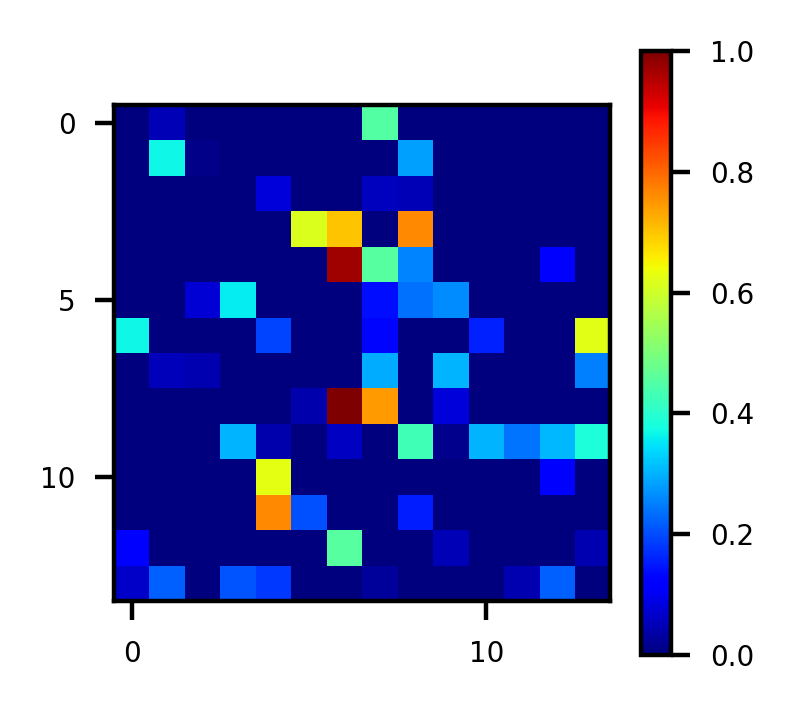

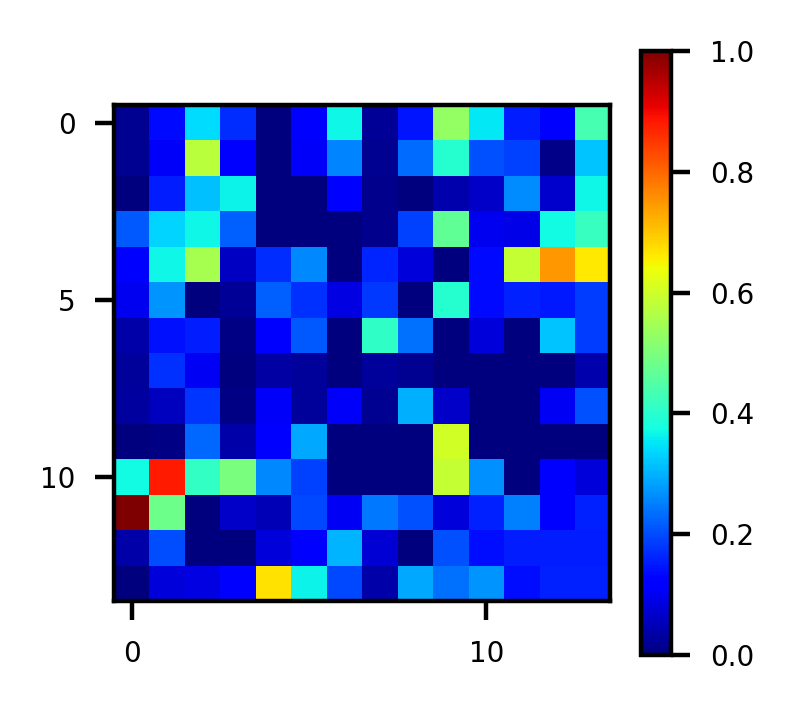

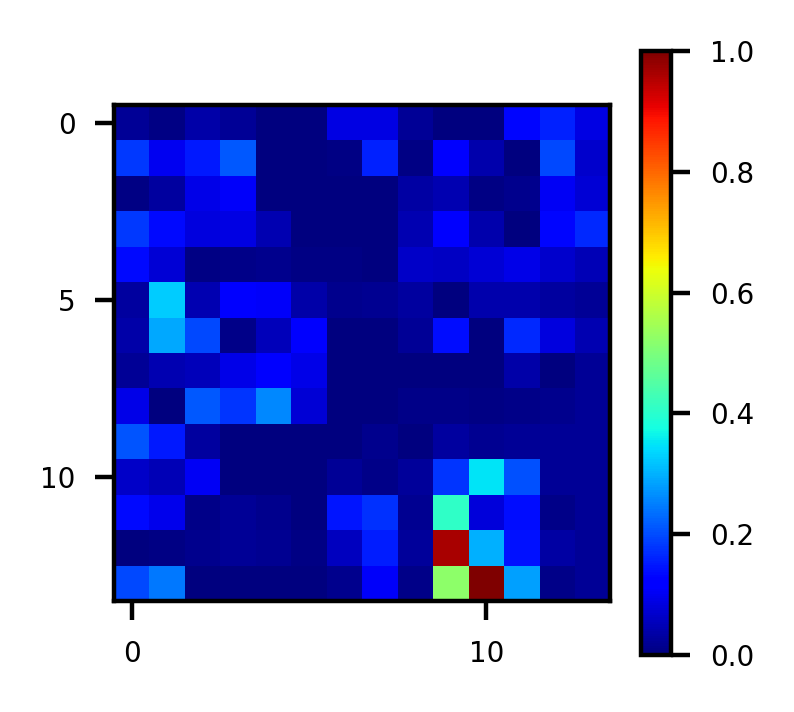

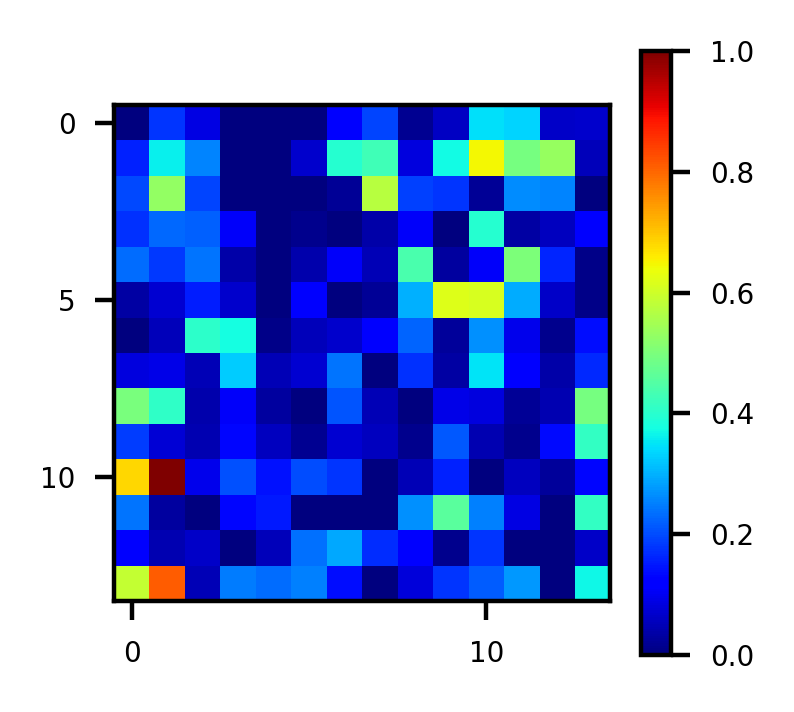

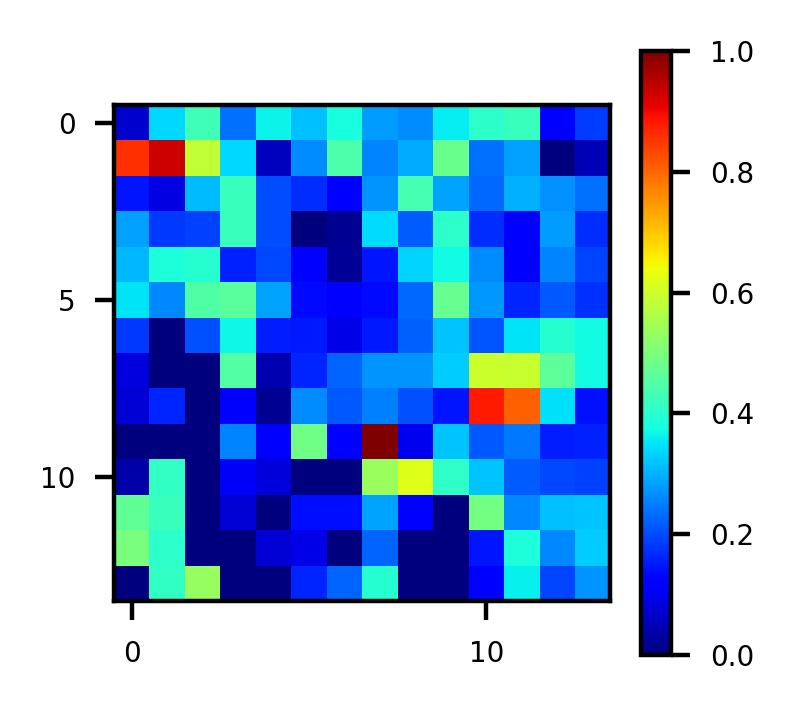

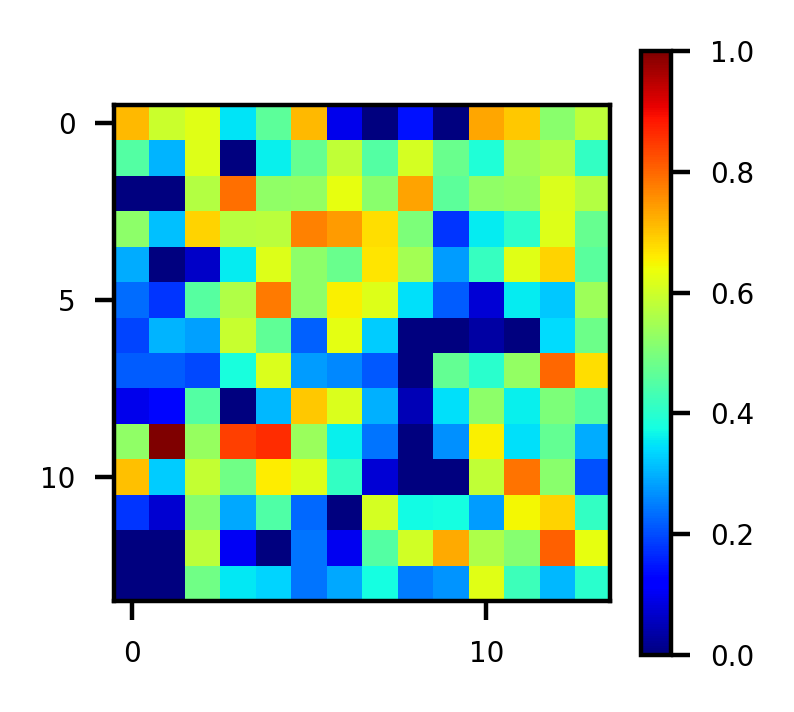

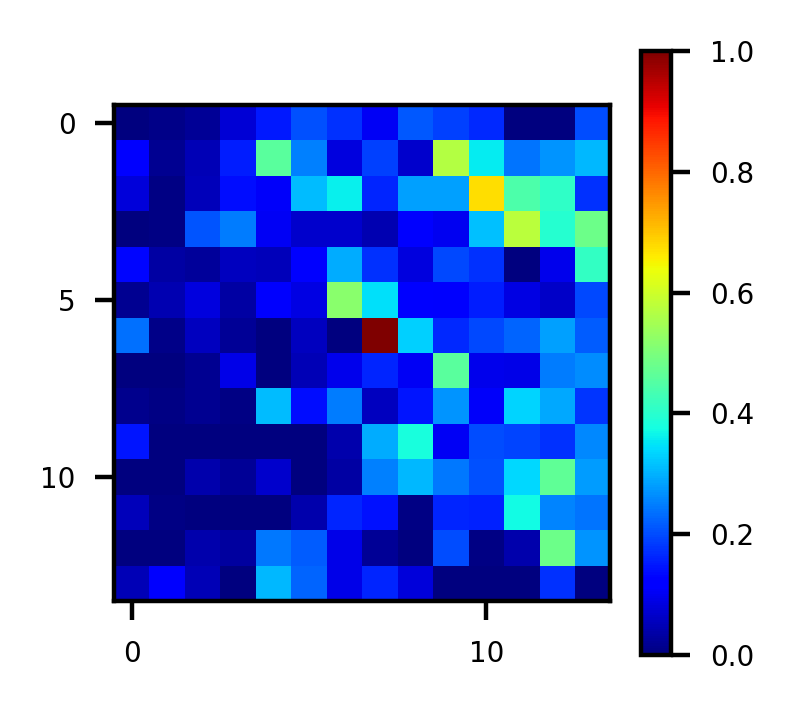

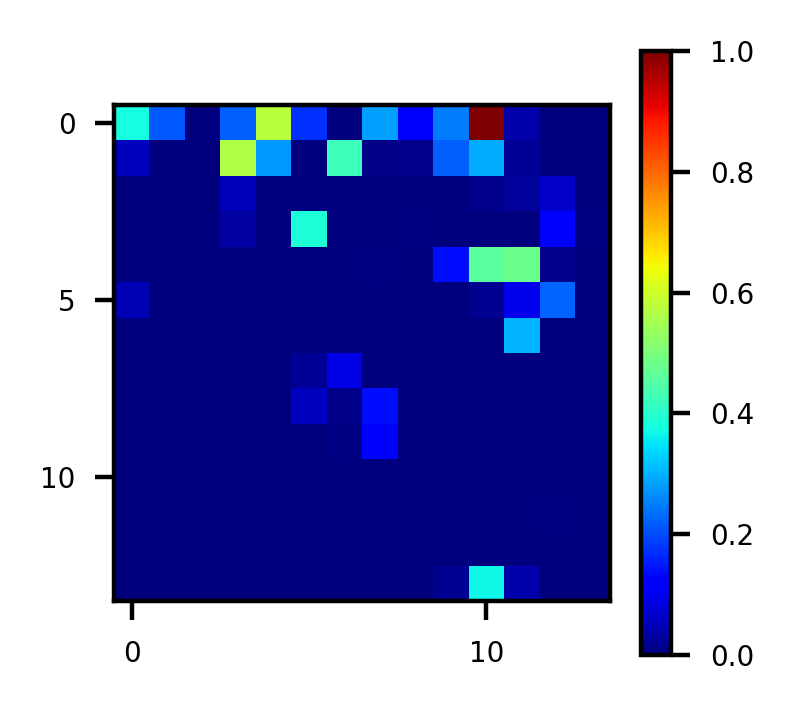

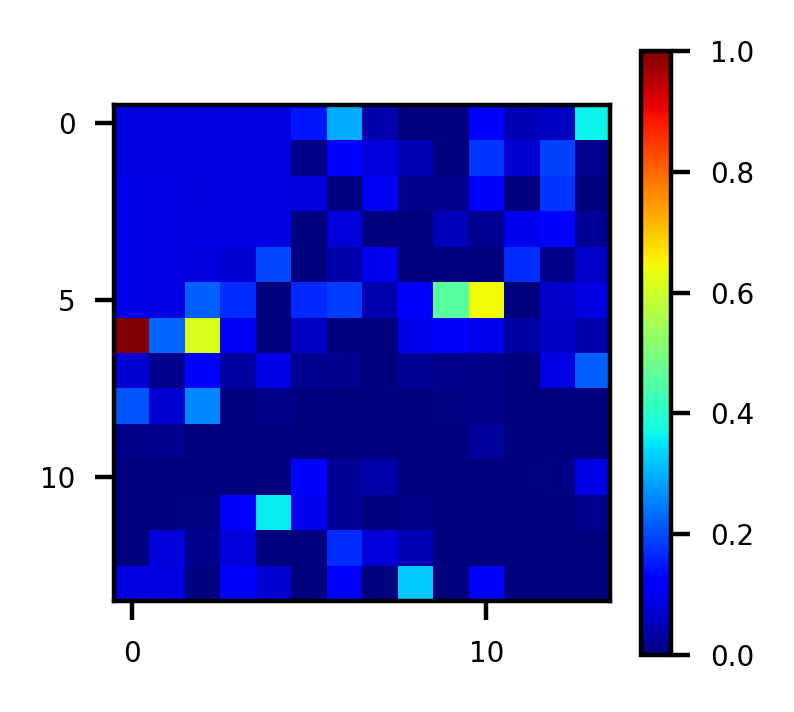

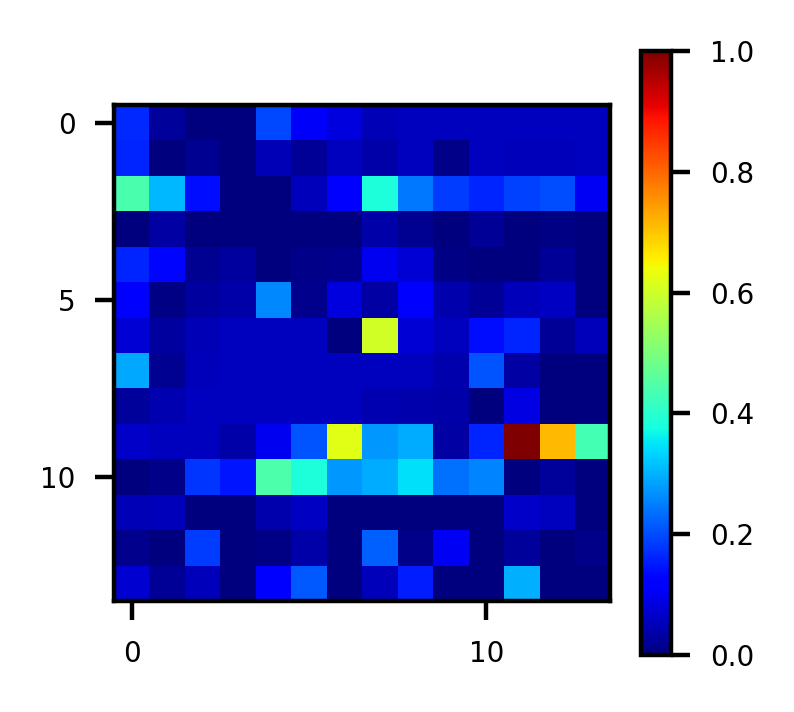

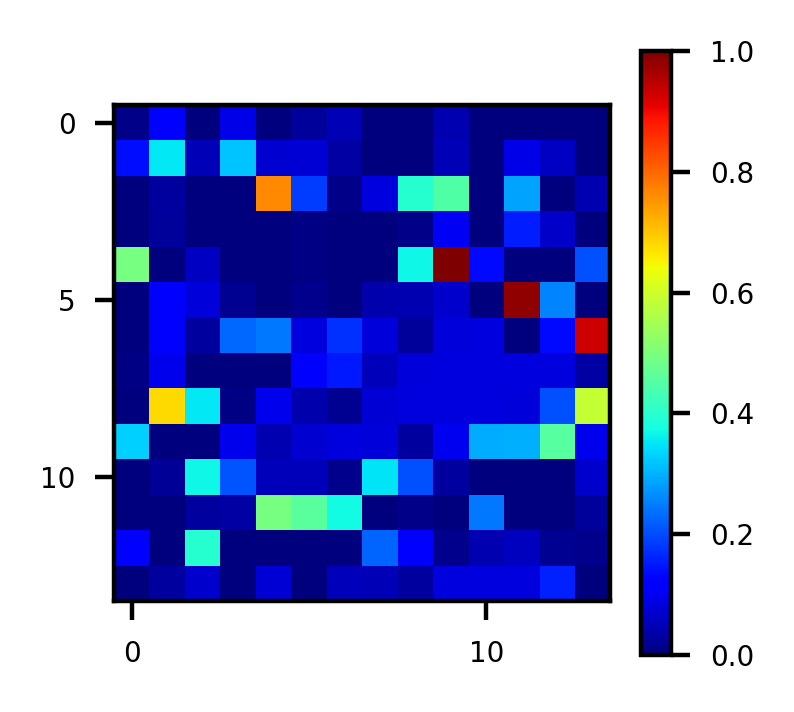

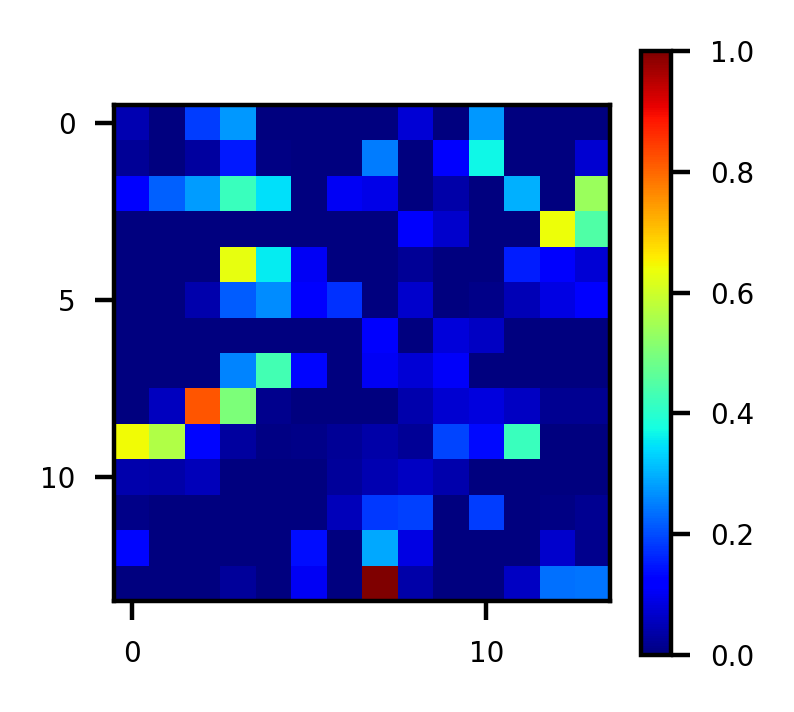

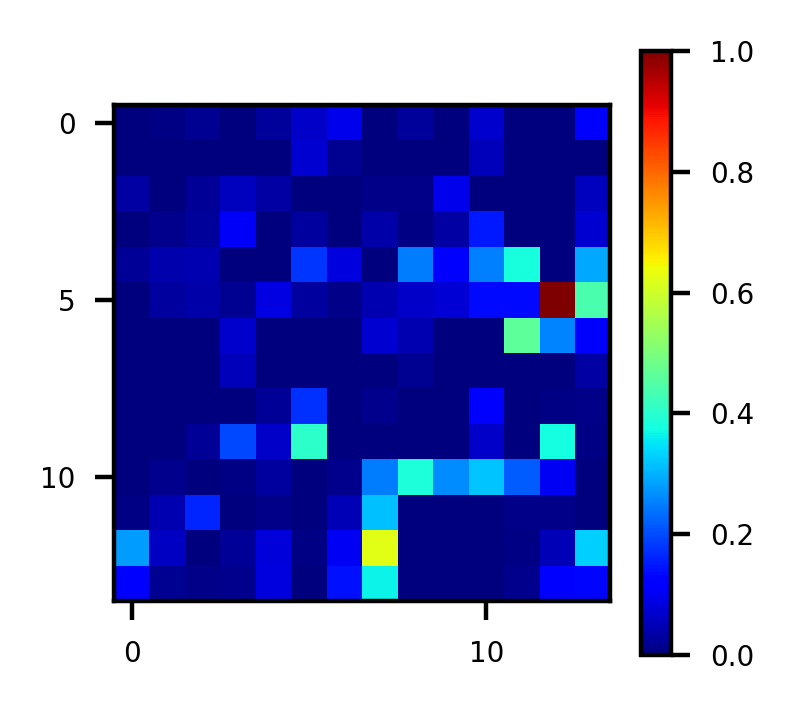

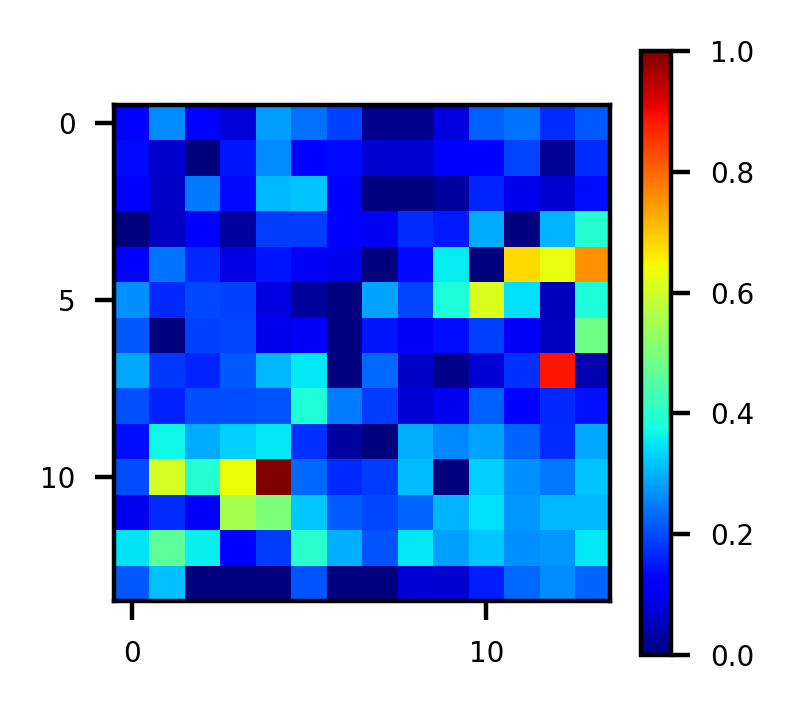

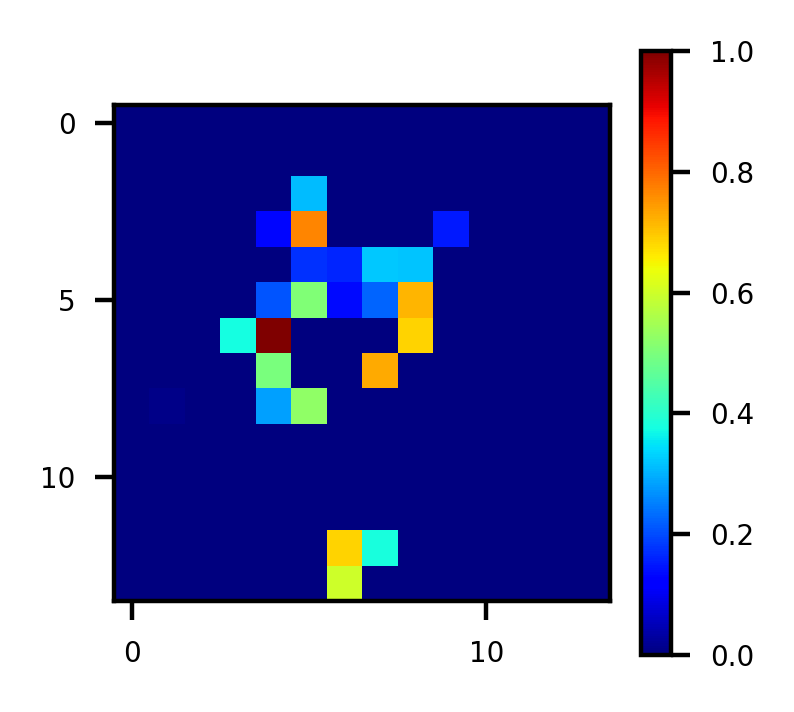

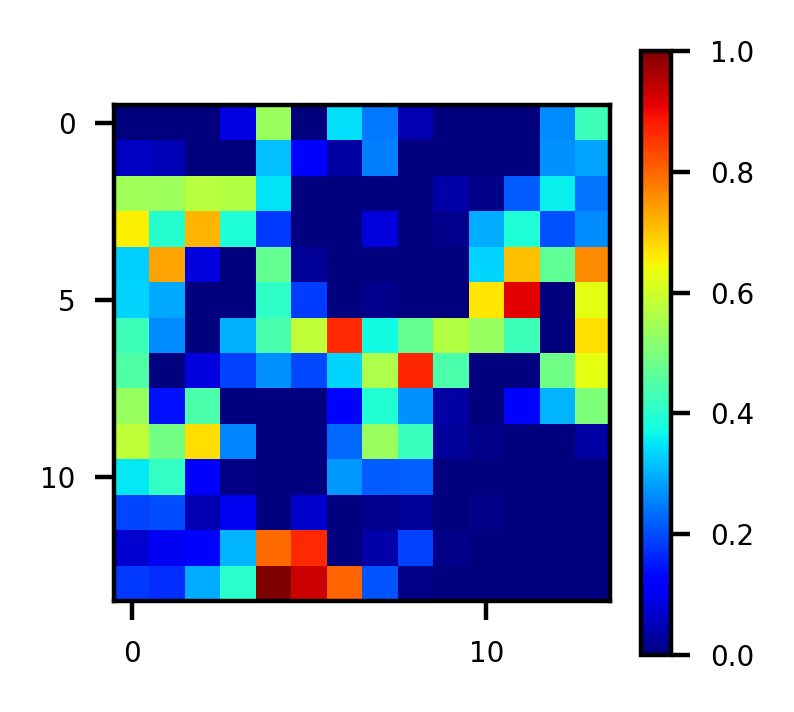

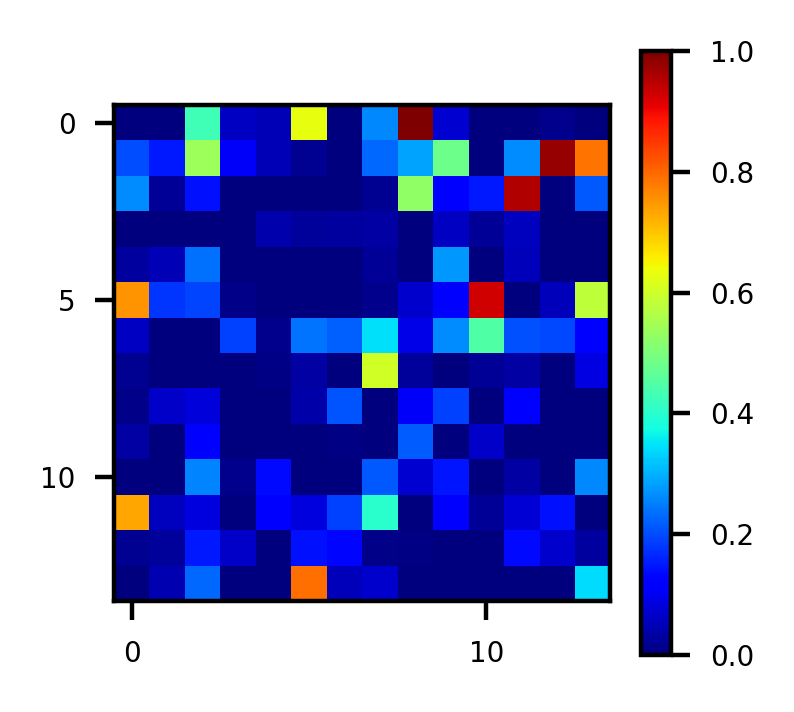

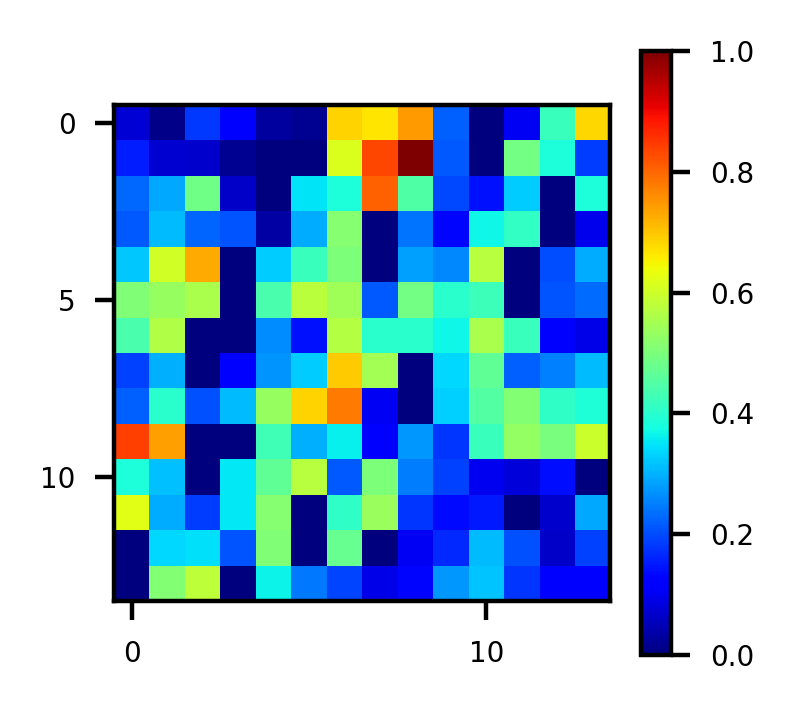

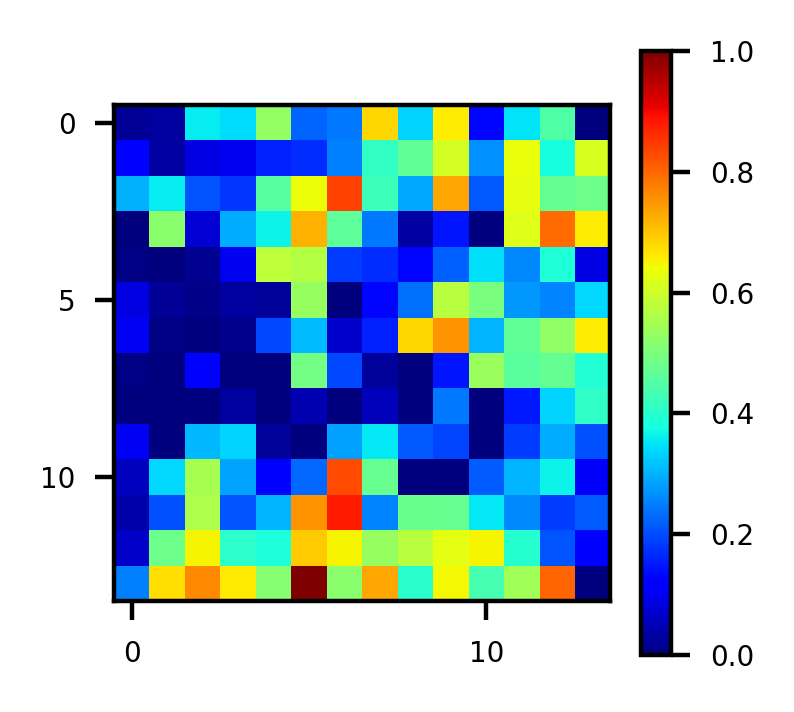

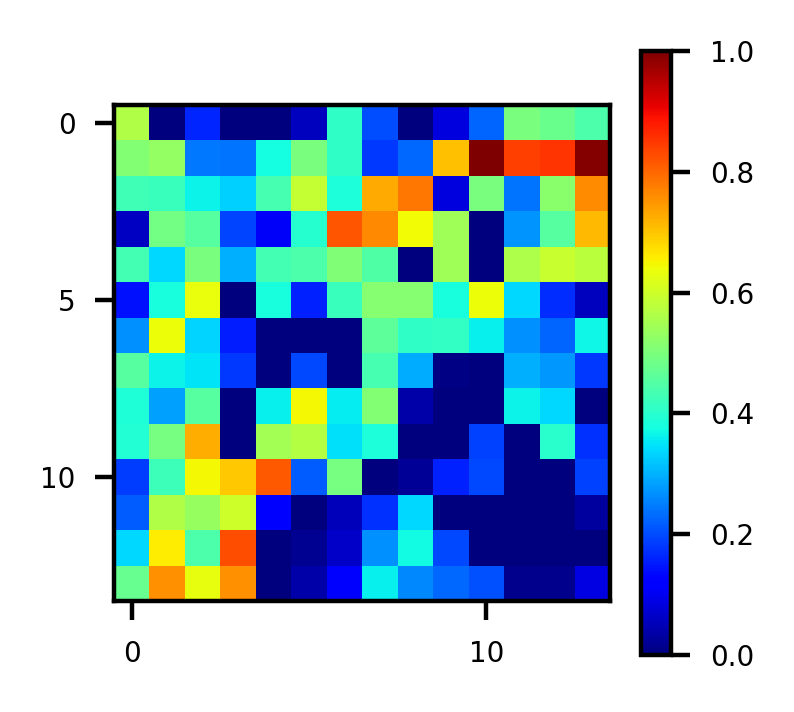

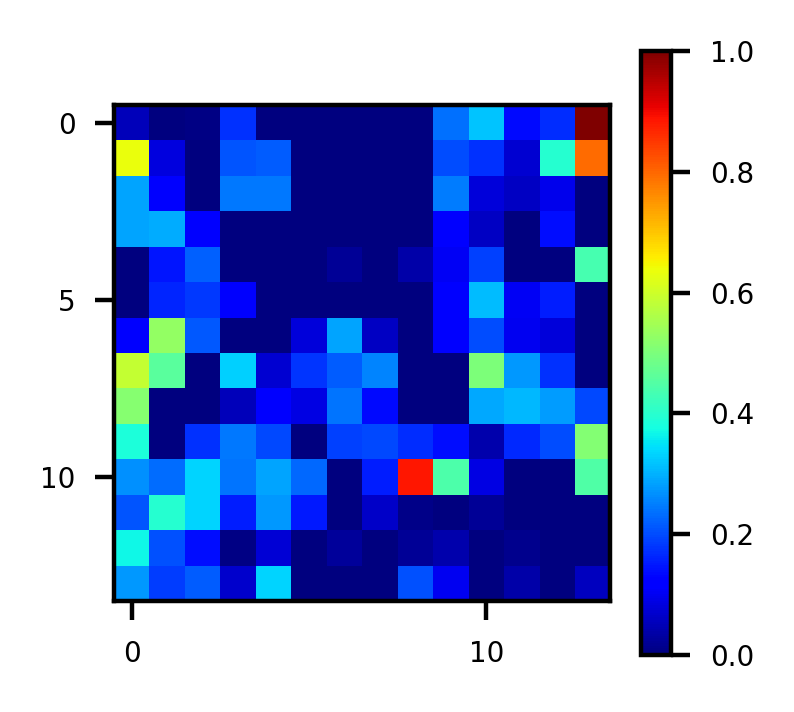

In [38]:
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        image_path = os.path.join(folder_path, filename)
        
        # Load and preprocess the image
        img_array = get_img_array(image_path, size=img_size)
        
        # Print the top predicted class
        preds = model.predict(img_array)
        predicted_class = np.argmax(preds)
        print(f"Image: {filename}, Predicted Class: {predicted_class}")
        
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_4')

        # Create a larger figure and set the resolution
        plt.figure(figsize=(2, 2), dpi=400)

        # Display the heatmap with more details
        plt.imshow(heatmap, cmap='jet',  interpolation='nearest')

        # Add a colorbar for reference
        plt.colorbar().ax.tick_params(labelsize=5)
        
        # Set the font size of the tick labels
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)

        # Save the heatmap plot
        output_path = os.path.join(output_folder, f"{filename.split('.')[0]}_heatmap.jpg")
        plt.savefig(output_path, dpi=400)
        
        # Save and display the Grad CAM
        save_and_display_gradcam(image_path, heatmap, cam_path=output_path)